In [2]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

In [3]:
processed_dataset  = "processed_data"

# Neural networks micro framework

In [4]:
import jax
import jax.numpy as jnp
from jax import lax
from jax.lax import dynamic_slice

In [5]:
def conv3D(grid,W):
    G = grid.copy()
    def relu(x):
        return jnp.maximum(0,x)
    
    # put zeros "around"
    G = jnp.pad(G,int(W.shape[0]/2))
    
    G = jax.vmap(
            lambda i:
            jax.vmap(
                lambda j:
                jax.vmap(
                    lambda k:
                        ( 
                                (dynamic_slice( G,(i - int(W.shape[0] / 2.) , j - int(W.shape[1] / 2.), k - int(W.shape[2] / 2.)) , 
                                      (W.shape[0],W.shape[1],W.shape[2]) ) * W).sum()
                        )
                )( jnp.arange( int(W.shape[2] / 2.) ,G.shape[2] - int(W.shape[2] / 2.)).astype(int) )
            )( jnp.arange( int(W.shape[1] / 2.), G.shape[1] - int(W.shape[1] / 2.)).astype(int) )
        )( jnp.arange( int(W.shape[0] / 2.), G.shape[0] - int(W.shape[0] / 2.)).astype(int) )
        
    return G
conv3D = jax.jit(conv3D)

In [6]:
def relu(x,w = 1.,b = 0.):
    return jnp.maximum(0,x * w + b)

def sigmoid(x,w = 1.,b = 0.):
    return (jnp.tanh(x * w + b) + 1.)/2.

def tanh(x,w=1.,b=0.):
    return jnp.tanh(x * w + b)

In [7]:
def linear(layer,W,b):
    return W @ layer + b

def add(layer,b):
    return layer + b

# Loading npy(s)

In [36]:
import os
N = len(next(os.walk("%s/voxelizations" % processed_dataset))[2])


# carico il training set
print("Caricamento training set...")

voxelizations      = []
voxelization_specs = []
centers_of_mass    = []
finger_prints      = []


for i in range(N):
    voxelization       = jnp.array(np.load("%s/voxelizations/voxelization_%d.npy"           % (processed_dataset,i)))
    voxelization_spec  = jnp.array(np.load("%s/voxelization_specs/voxelization_spec_%d.npy" % (processed_dataset,i)))
    center_of_mass     = jnp.array(np.load("%s/centers_of_mass/center_of_mass_%d.npy"       % (processed_dataset,i)))
    finger_print       = jnp.array(np.load("%s/finger_prints/finger_print_%d.npy"           % (processed_dataset,i)))
    
    voxelization_specs.append(voxelization_spec)
    voxelizations.append(voxelization)
    centers_of_mass.append(center_of_mass)
    finger_prints.append(finger_print)
    
    if int( i / (N / 10)) != int( (i + 1)/ (N/10) ):
        print("%d su %d" % (i , N))

Caricamento training set...
10 su 101
20 su 101
30 su 101
40 su 101
50 su 101
60 su 101
70 su 101
80 su 101
90 su 101
100 su 101


In [37]:
shapes      = np.array([ np.array(a.shape) for a in voxelizations ])
magic_shape = shapes.max(axis = 0)
magic_shape

array([74, 66, 81])

## Conversione dei dati caricati in formato array

In [53]:
voxelizations       = [ jnp.array(o) for o in voxelizations      ]
voxelization_specs  = [ jnp.array(o) for o in voxelization_specs ]
centers_of_mass     = [ jnp.array(o) for o in centers_of_mass    ]
finger_prints       = [ jnp.array(o) for o in finger_prints      ]

# Center of mass gaussianization

In [54]:
def center_of_mass_gaussianization(
        com,                      # centro di massa
        voxelization_orig_shape , # dimensione della voxelizzazione prima di essere paddata
        voxelization_specs      , # specifiche geometriche della voxelizzazioen (xmin,xmax,ymin,ymax,zmin,zmax)
        sigma = 5.                # deviazione standard della gaussiana
):
    # ritorna una voxelgrid in cui il centro di massa é rappresentato attraverso una gaussiana 
    # di varianza sigma_sq
    
    grid = np.zeros((voxelization_orig_shape[0],
                     voxelization_orig_shape[1],
                     voxelization_orig_shape[2]))
    
    x_min,x_max,y_min,y_max,z_min,z_max = voxelization_specs

    X   = jnp.linspace(x_min,x_max, voxelization_orig_shape[0])
    Y   = jnp.linspace(y_min,y_max, voxelization_orig_shape[1])
    Z   = jnp.linspace(z_min,z_max, voxelization_orig_shape[2])
    
    # faccio il meshgrid dei linspace
    XYZ = jnp.meshgrid(X,Y,Z, indexing = 'ij')

    
    grid =  jax.vmap(
                        lambda x,y,z: 
                            jnp.exp( - (
                                        (x - com[0])**2 +      
                                        (y - com[1])**2 + 
                                        (z - com[2])**2
                                       ) / (sigma**2)           # divido per la varianza
                                   )
                    )(XYZ[0],
                      XYZ[1],
                      XYZ[2])


    grid = np.array(grid)
    return grid
    

In [55]:
voxelization_specs[0]

DeviceArray([-1.307, 26.864, -9.073, 20.774, 13.342, 41.422], dtype=float32)

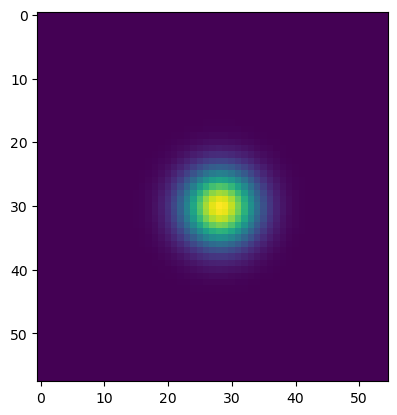

In [56]:
com_g = center_of_mass_gaussianization(
    centers_of_mass[0],
    voxelizations[0].shape,
    voxelization_specs[0],
    3.
)
plt.imshow(com_g.mean(axis = 0))

# Padding

In [57]:
def padding(array, requested_shape):
    xx = requested_shape[0]
    yy = requested_shape[1]
    zz = requested_shape[2]
    
    sa = array.shape[0]
    sb = array.shape[1]
    sc = array.shape[2] 
    
    a = (xx - sa) // 2
    aa = xx - a - sa
    b = (yy - sb) // 2
    bb = yy - b - sb
    c = (zz - sc) // 2
    cc = zz - c - sc
    
    return jnp.pad(array, pad_width=((a, aa), (b, bb), (c,cc)), mode='constant')

In [77]:
def extract_batch(magic_shape     ,   # magic shape
                  voxel_list      ,   # lista delle voxelizzazioni 
                  voxel_spec_list ,   # lista delle specifiche delle voxelizzazioni
                  com_list        ,   # lista dei centri di massa
                  sigma           ,   # sigma 
                  idx_list):          # lista degli indici da prendere
    return (
            jnp.array([                                       # padding delle voxelizzazioni
                    padding(
                        voxel_list[idx] , 
                        magic_shape
                    )
                for idx in idx_list
            ]),
            jnp.array([
                    padding(
                        center_of_mass_gaussianization(
                            com_list[idx],
                            voxel_list[idx].shape,
                            voxel_spec_list[idx],
                            sigma
                        ),
                        magic_shape
                    )
                for idx in idx_list
            ])
    )

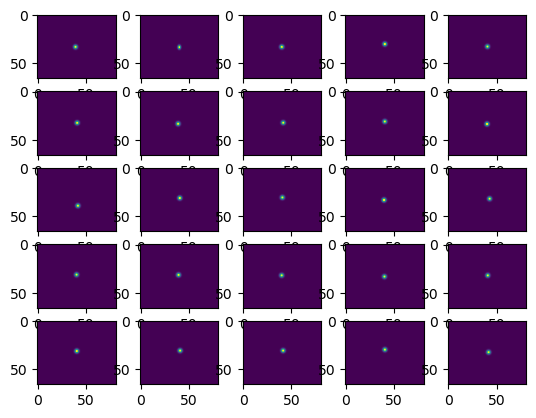

In [78]:
n = 5
vox,com = extract_batch(
    magic_shape,
    voxelizations,
    voxelization_specs,
    centers_of_mass,
    sigma = 1.0,
    idx_list = np.random.choice(len(voxelizations), size = (n**2))
)

axs = plt.figure().subplots(n,n).flatten()
for i,a in enumerate(axs):
    a.imshow(com[i].mean(axis = 0))
    

# Network

###  Rete

In [79]:
def logistic_model(kernels_tensor_flux, 
                   biases_tensor_flux,                   
                   grid):
        
    x            = conv3D(grid, 
                          kernels_tensor_flux[0])
    x            = relu(x ,
                        b = biases_tensor_flux[0])
    
    for W,b in zip(kernels_tensor_flux[1:][:-1], biases_tensor_flux[1:][:-1]):
        x        = conv3D(x,  W)
        x        = relu(x,b = b)
    
    x            = conv3D(x, kernels_tensor_flux[-1])
    x            =    add(x, biases_tensor_flux[-1] )
    
    return x
    

def generate_params_big_model( flux_topology ):
    
    kernels_tensor_flux = []
    biases_tensor_flux  = []
    
    for k in flux_topology:
        kernels_tensor_flux.append( 
            jnp.array(
                np.random.normal(
                    size = (k,k,k)
                ) 
                * 
                np.sqrt(
                    2./ (k * k * k)
                )
            ) 
        )
        biases_tensor_flux.append(0.)

    
    return kernels_tensor_flux, biases_tensor_flux

### Loss function

In [80]:
def loss(    
       kernels_tensor_flux, 
       biases_tensor_flux,
       grid,
       A):
    
    A_hat = logistic_model(
                   kernels_tensor_flux, 
                   biases_tensor_flux,
                   grid)
    
    
    return ((A - A_hat)**2).mean()


loss = jax.jit(loss)
grad = jax.grad(loss,argnums = (0,1))
grad = jax.jit(grad)

In [81]:
def batch_loss(    
                   kernels_tensor_flux, 
                   biases_tensor_flux,
    
                   grids,
                   As):
    
    
        return jax.vmap(
          lambda 
              grid, A:
              (
                  (
                    logistic_model( 
                                    kernels_tensor_flux, 
                                    biases_tensor_flux,
                                    grid
                                   ) 
                     - A)**2 * (A > 0.0)
                   ).mean() / (A > 0.0).mean()
              )(
                  grids,
                  As
              ).mean()
    
batch_loss = jax.jit(batch_loss)
batch_grad = jax.grad(batch_loss,argnums = (0,1))
batch_grad = jax.jit(batch_grad)

# Training

## Random generated parameters

In [96]:
np.random.seed(123)
ktf, btf = generate_params_big_model( [3 for k in range(18)])

## Training Loop

$(1 - T)^E\sigma_0 = \sigma_F$ <br>
$log\left( (1 - T)^E\sigma_0 \right) = log \left( \sigma_F \right)$ <br>
$log\left( (1 - T)^E \right) + log\left( \sigma_0 \right) = log \left( \sigma_F \right)$ <br>
$E log\left( (1 - T) \right) + log\left( \sigma_0 \right) = log \left( \sigma_F \right)$ <br>
$log\left( (1 - T) \right)  = \frac{1}{E} \left( log \left( \sigma_F \right) - log\left( \sigma_0 \right) \right)$ <br>
$\left( (1 - T) \right)  =  exp ( \frac{1}{E} \left( log \left( \sigma_F \right) - log\left( \sigma_0 \right) \right) )$<br>
$ -T  =  - 1 + exp ( \frac{1}{E} \left( log \left( \sigma_F \right) - log\left( \sigma_0 \right) \right) )$ <br>
$ T  =  1 - exp ( \frac{1}{E} \left( log \left( \sigma_F \right) - log\left( \sigma_0 \right) \right) )$ 
<br>

sigma = 1.99723
0
	0.00102
	0.00079
	0.00081
	0.00083
	0.00088
	0.00069
	0.00084
	0.00083
	0.00075
	0.00067


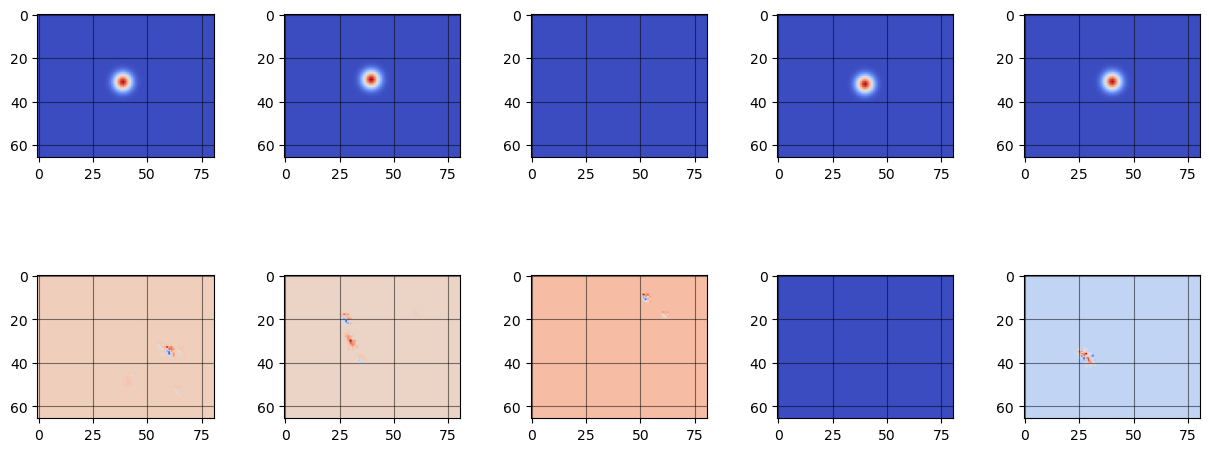

0.0008109732
sigma = 1.99446
1
	0.00077
	0.00076
	0.00082
	0.00077
	0.00070
	0.00082
	0.00086
	0.00086
	0.00068
	0.00076


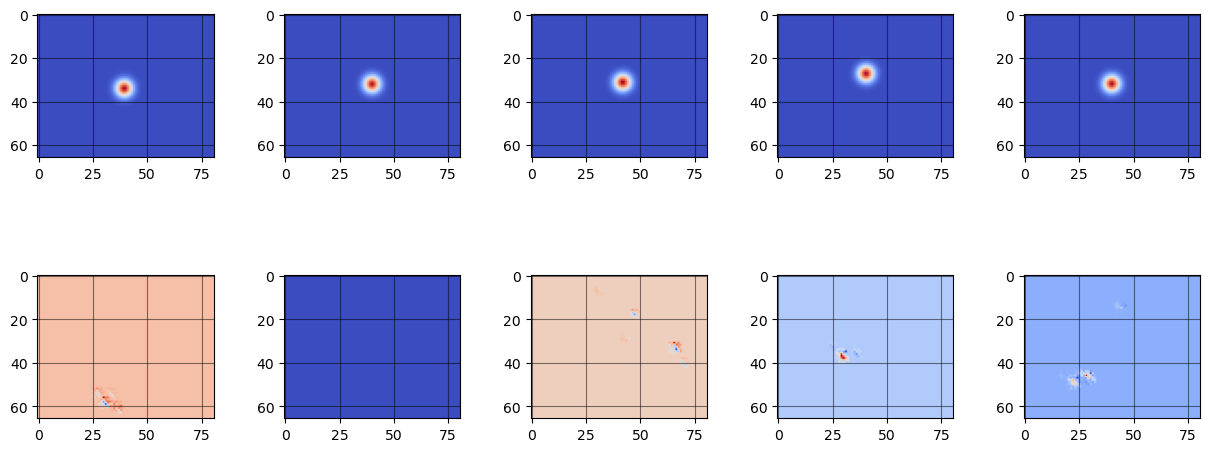

0.00077945524
sigma = 1.99170
2
	0.00074
	0.00077
	0.00084
	0.00072
	0.00084
	0.00066
	0.00080
	0.00081
	0.00076
	0.00084


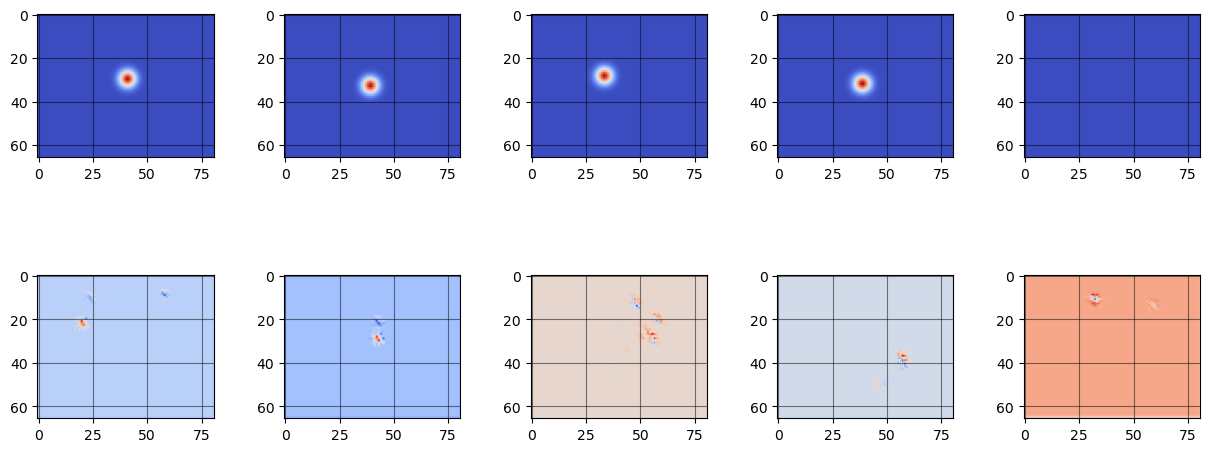

0.0007769888
sigma = 1.98894
3
	0.00078
	0.00075
	0.00079
	0.00066
	0.00080
	0.00080
	0.00080
	0.00081
	0.00078
	0.00076


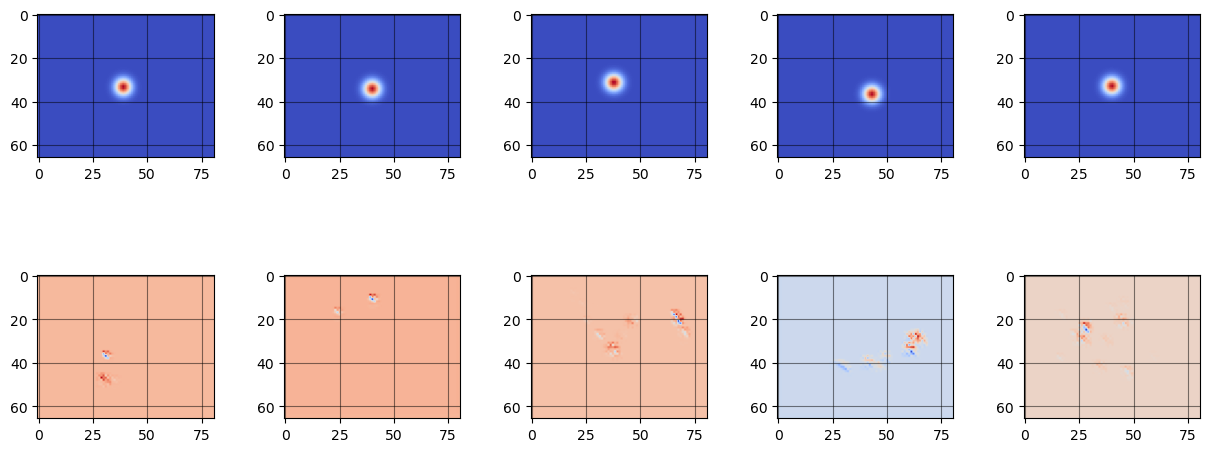

0.00077397947
sigma = 1.98618
4
	0.00081
	0.00073
	0.00071
	0.00081
	0.00077
	0.00074
	0.00079
	0.00085
	0.00077
	0.00073


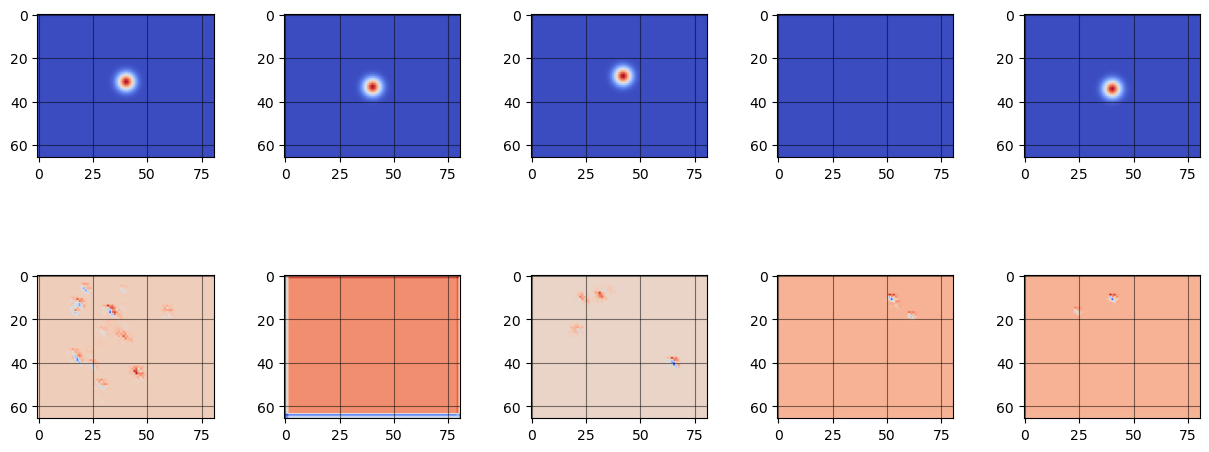

0.0007709997
sigma = 1.98343
5
	0.00070
	0.00072
	0.00072
	0.00076
	0.00083
	0.00073
	0.00085
	0.00085
	0.00074
	0.00079


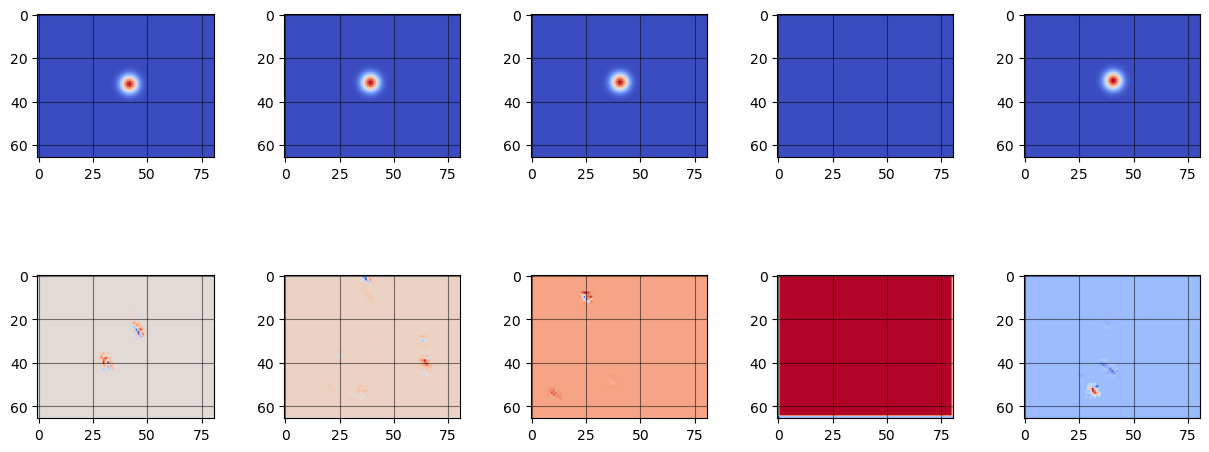

0.0007693987
sigma = 1.98069
6
	0.00075
	0.00074
	0.00075
	0.00085
	0.00074
	0.00067
	0.00070
	0.00082
	0.00080
	0.00083


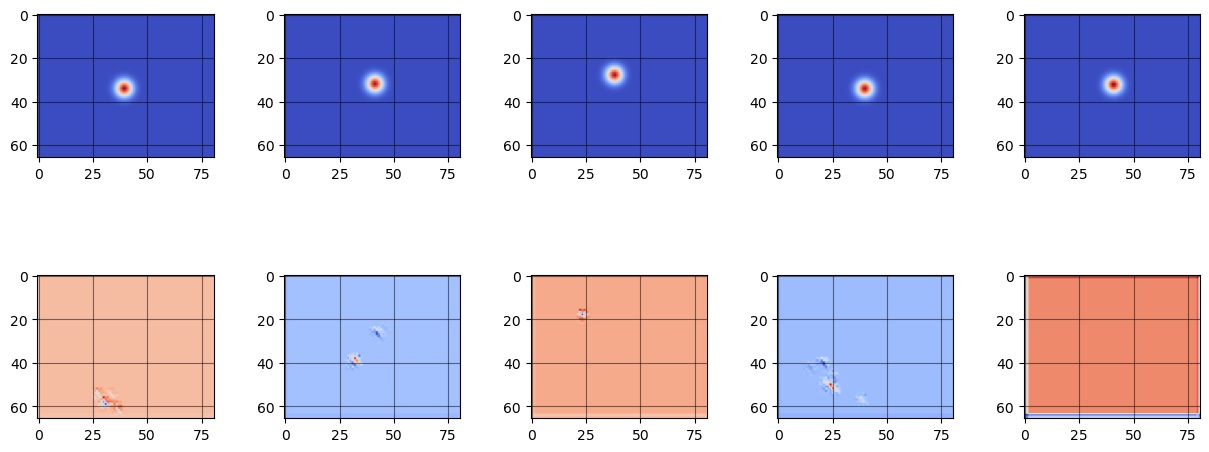

0.0007663074
sigma = 1.97794
7
	0.00074
	0.00076
	0.00080
	0.00081
	0.00074
	0.00075
	0.00081
	0.00078
	0.00074
	0.00072


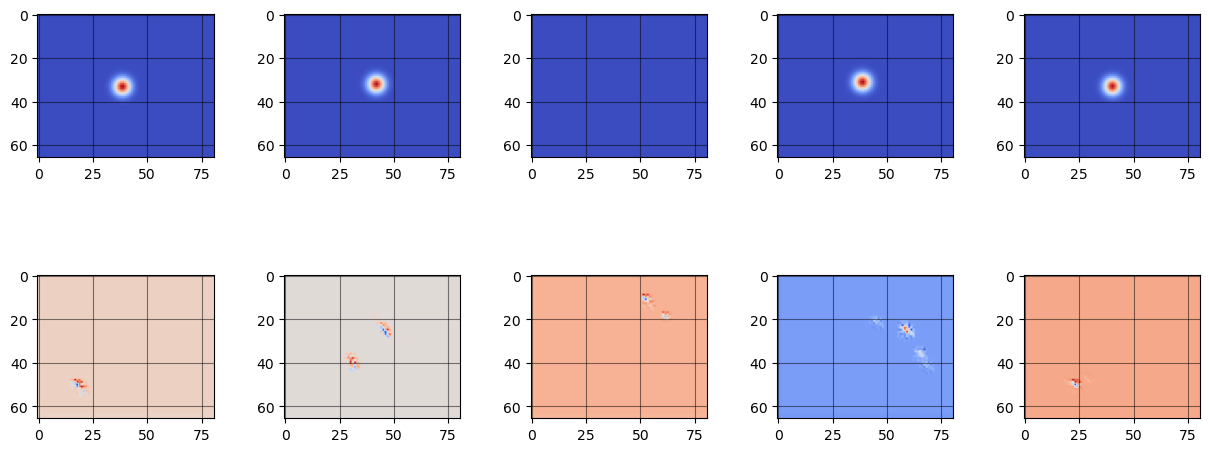

0.0007637938
sigma = 1.97520
8
	0.00071
	0.00068
	0.00070
	0.00074
	0.00069
	0.00082
	0.00085
	0.00081
	0.00082
	0.00081


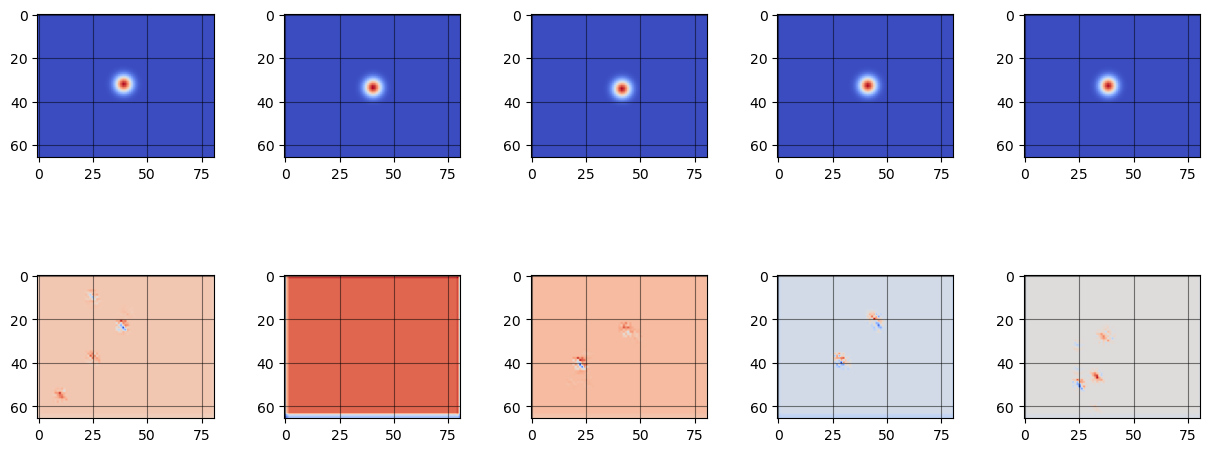

0.00076150335
sigma = 1.97247
9
	0.00070
	0.00076
	0.00070
	0.00081
	0.00076
	0.00082
	0.00081
	0.00073
	0.00079
	0.00070


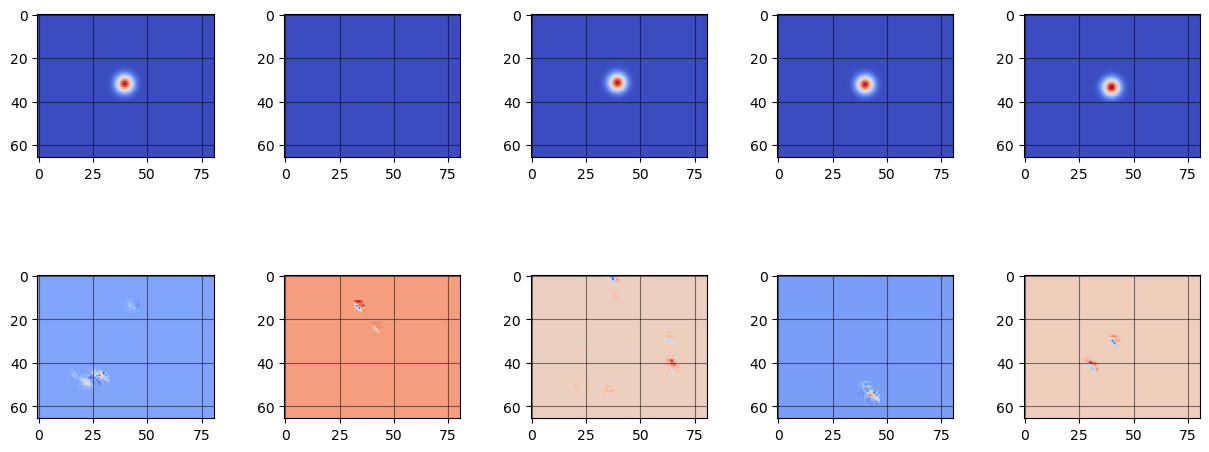

0.0007590524
sigma = 1.96973
10
	0.00079
	0.00080
	0.00071
	0.00069
	0.00078
	0.00075
	0.00075
	0.00070
	0.00086
	0.00072


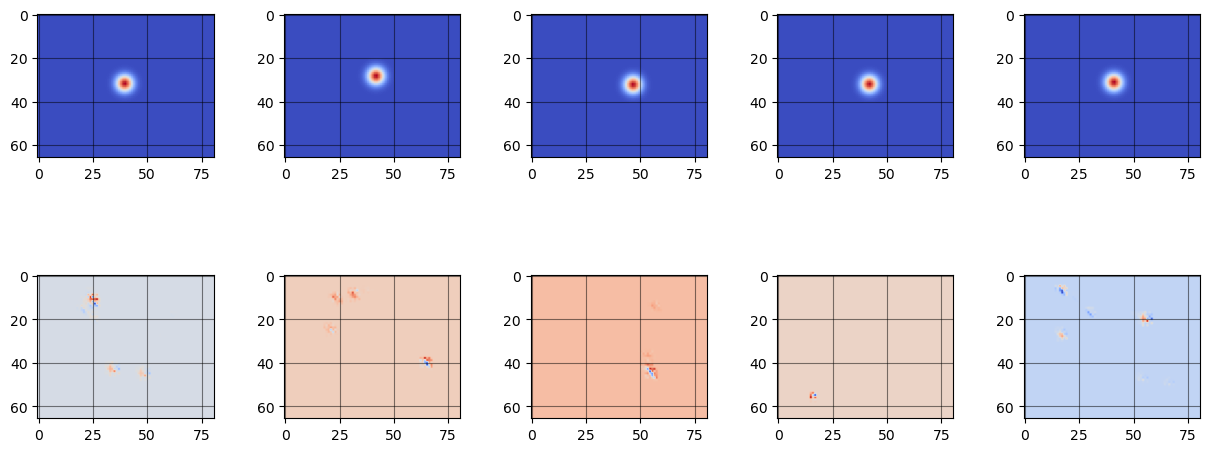

0.0007555677
sigma = 1.96700
11
	0.00073
	0.00078
	0.00084
	0.00074
	0.00087
	0.00073
	0.00071
	0.00073
	0.00072
	0.00068


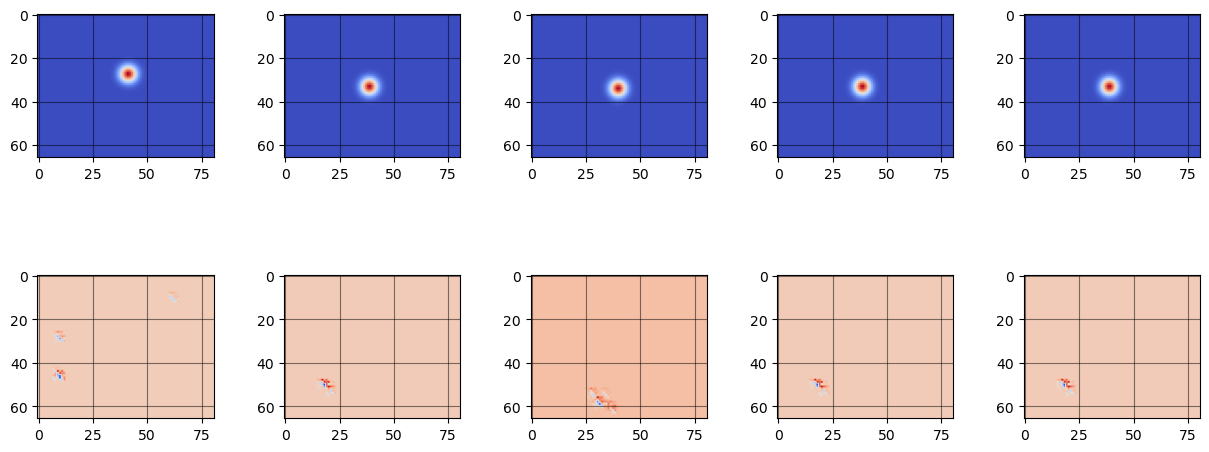

0.00075363636
sigma = 1.96428
12
	0.00068
	0.00078
	0.00077
	0.00077
	0.00074
	0.00072
	0.00071
	0.00073
	0.00081
	0.00081


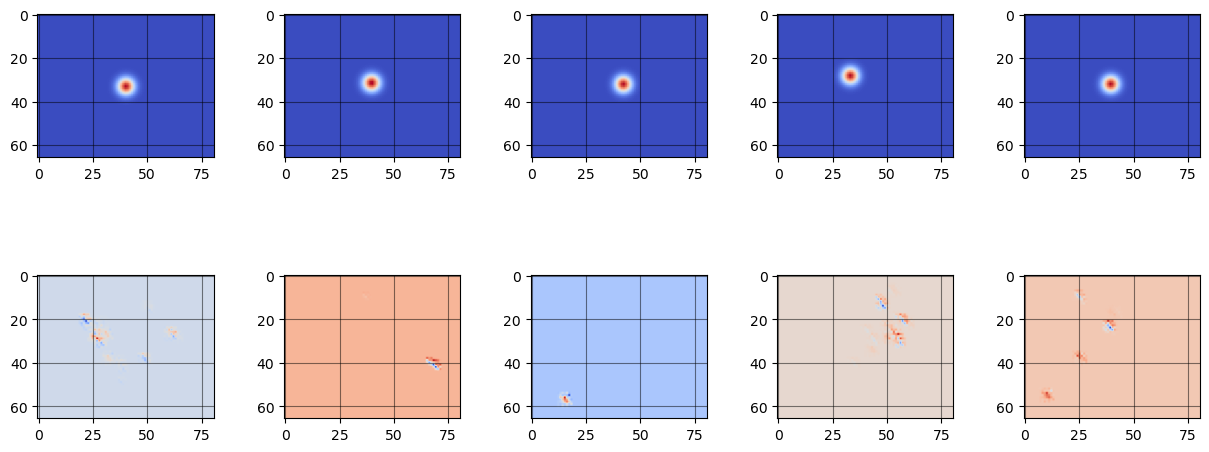

0.00075165025
sigma = 1.96156
13
	0.00077
	0.00077
	0.00065
	0.00074
	0.00072
	0.00074
	0.00078
	0.00078
	0.00078
	0.00076


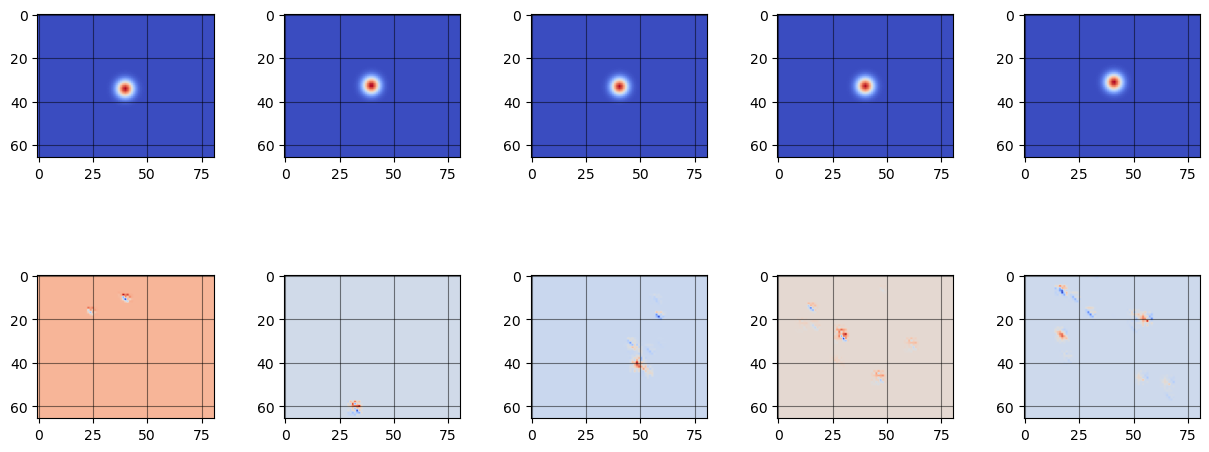

0.00074819394
sigma = 1.95884
14
	0.00071
	0.00080
	0.00070
	0.00081
	0.00073
	0.00082
	0.00071
	0.00074
	0.00066
	0.00079


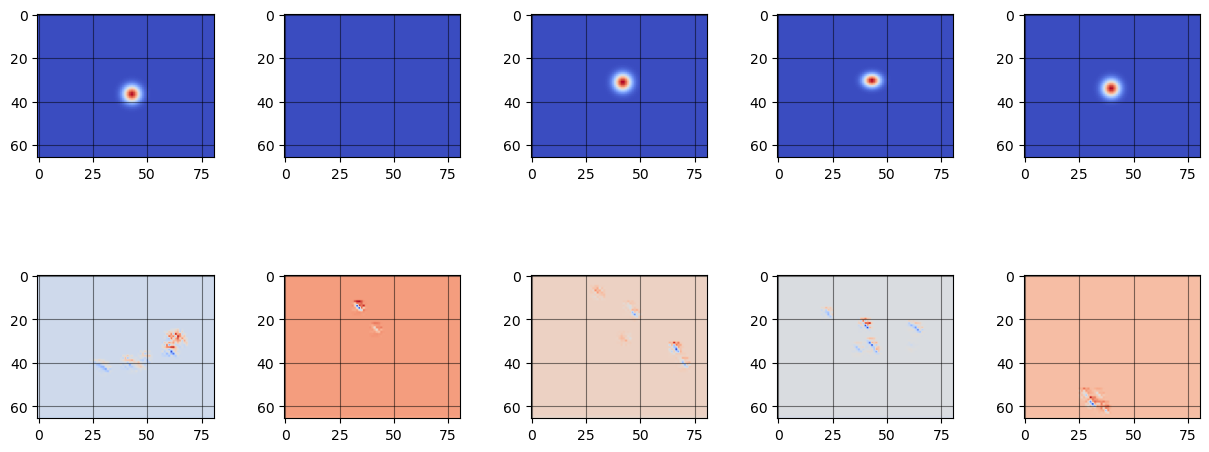

0.00074628677
sigma = 1.95613
15
	0.00071
	0.00067
	0.00074
	0.00076
	0.00071
	0.00069
	0.00087
	0.00080
	0.00081
	0.00067


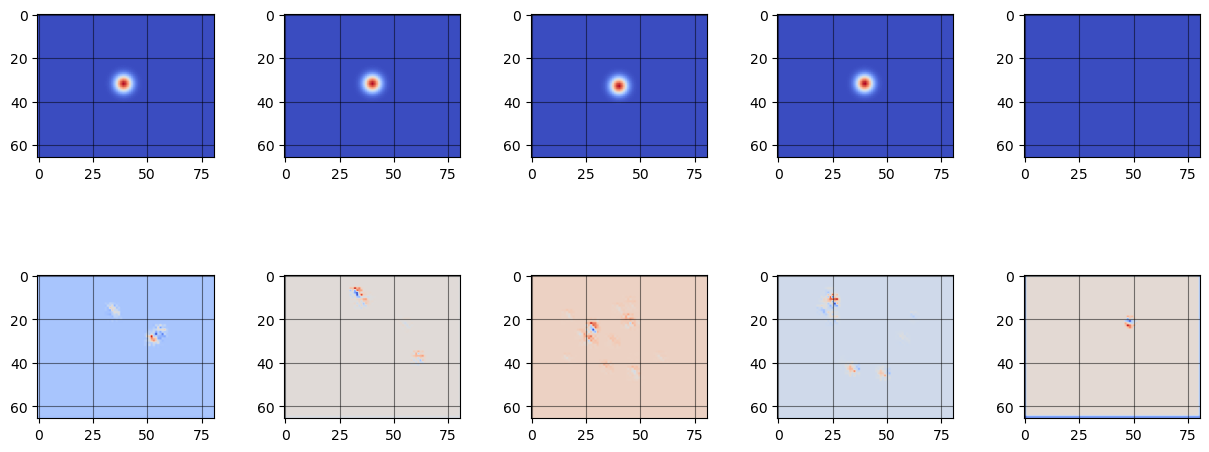

0.00074375153
sigma = 1.95342
16
	0.00066
	0.00071
	0.00076
	0.00077
	0.00075
	0.00072
	0.00077
	0.00075
	0.00073
	0.00080


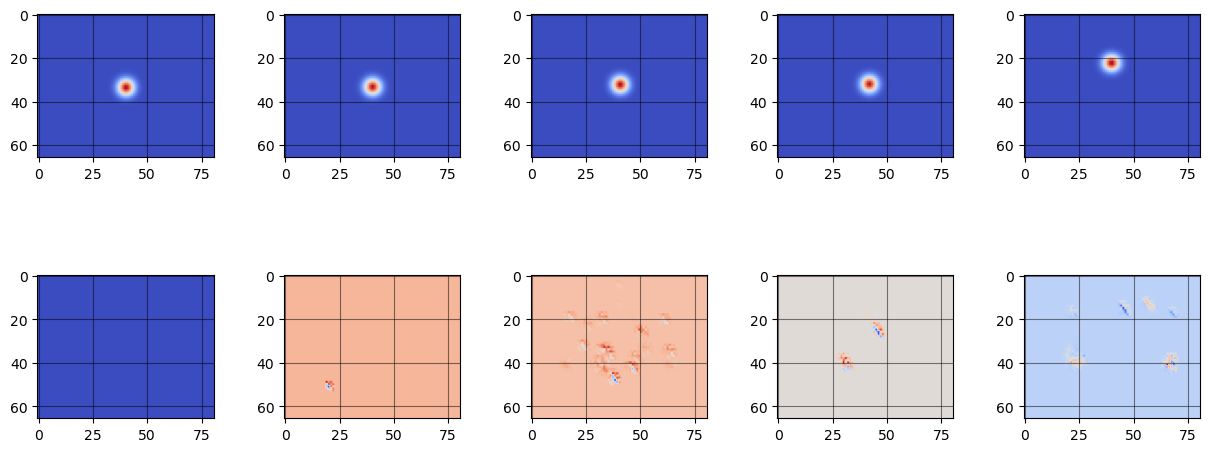

0.00074184785
sigma = 1.95071
17
	0.00068
	0.00069
	0.00070
	0.00073
	0.00079
	0.00079
	0.00080
	0.00078
	0.00073
	0.00071


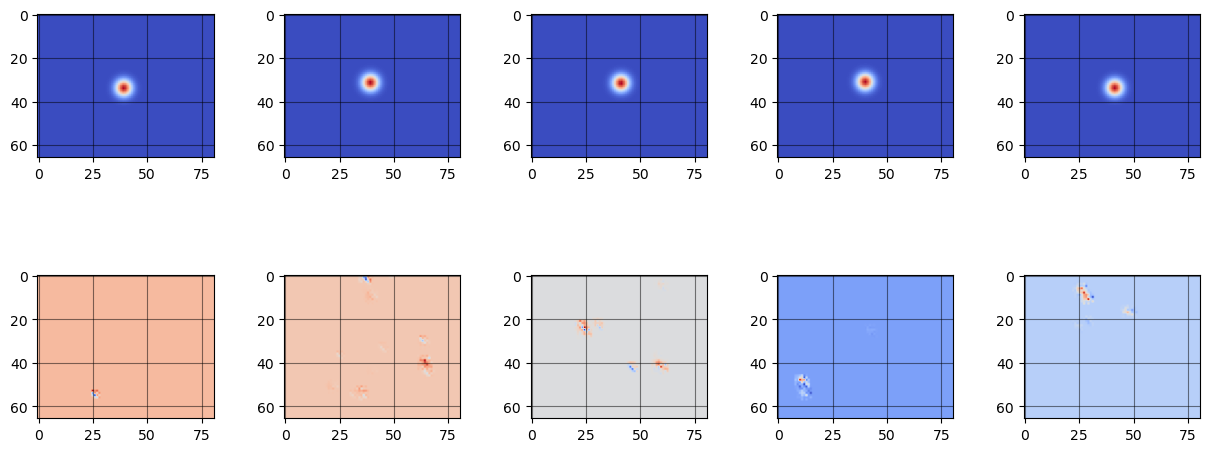

0.0007391932
sigma = 1.94801
18
	0.00075
	0.00071
	0.00072
	0.00071
	0.00076
	0.00069
	0.00075
	0.00080
	0.00069
	0.00078


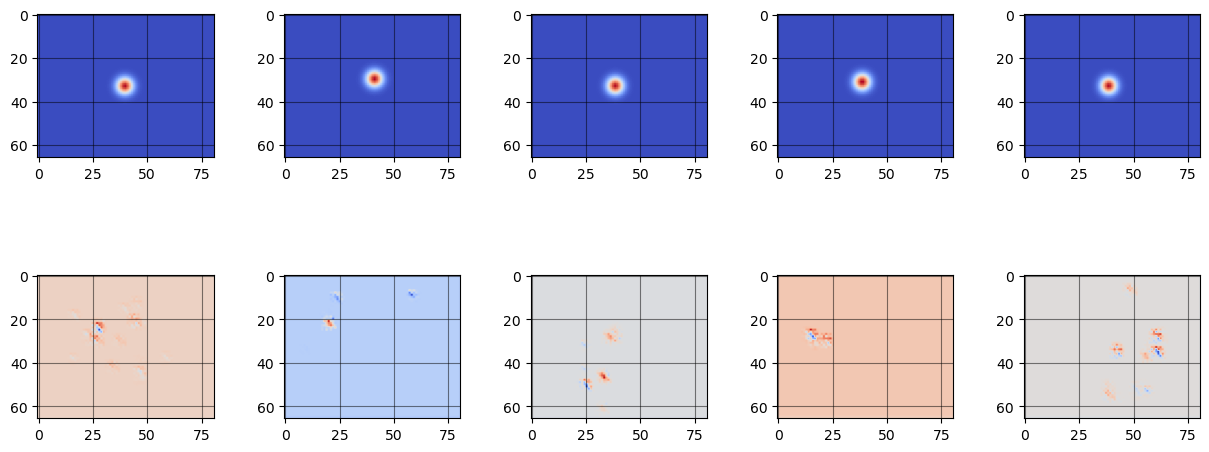

0.00073605403
sigma = 1.94531
19
	0.00075
	0.00078
	0.00070
	0.00069
	0.00077
	0.00074
	0.00077
	0.00071
	0.00069
	0.00073


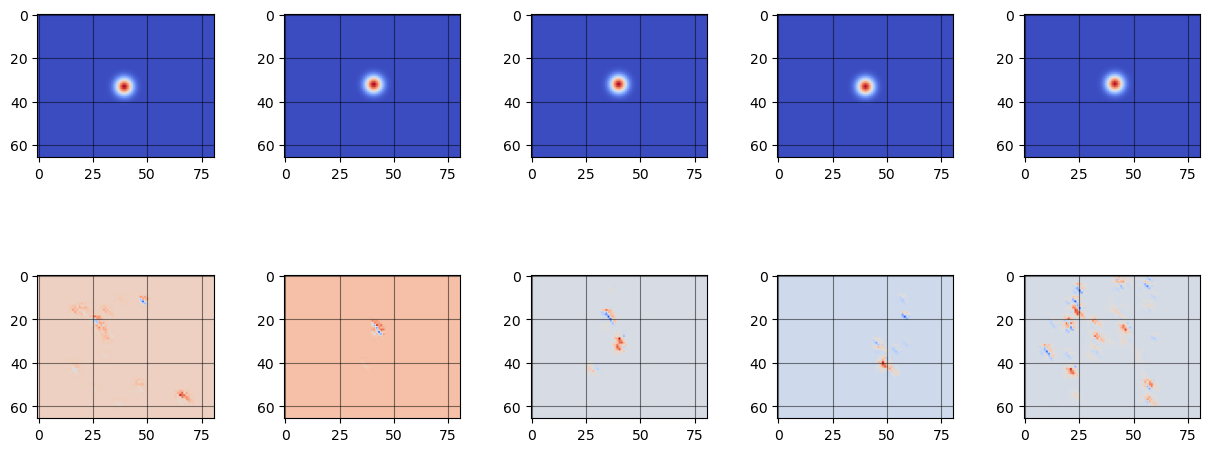

0.00073365564
sigma = 1.94261
20
	0.00068
	0.00075
	0.00079
	0.00075
	0.00075
	0.00078
	0.00076
	0.00065
	0.00077
	0.00063


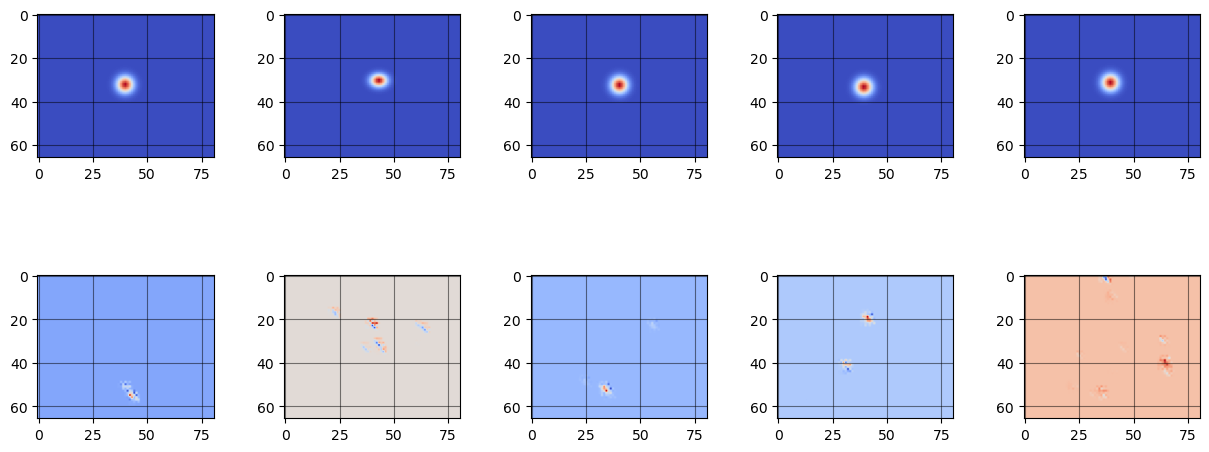

0.00073184806
sigma = 1.93992
21
	0.00080
	0.00076
	0.00076
	0.00078
	0.00067
	0.00076
	0.00069
	0.00065
	0.00069
	0.00074


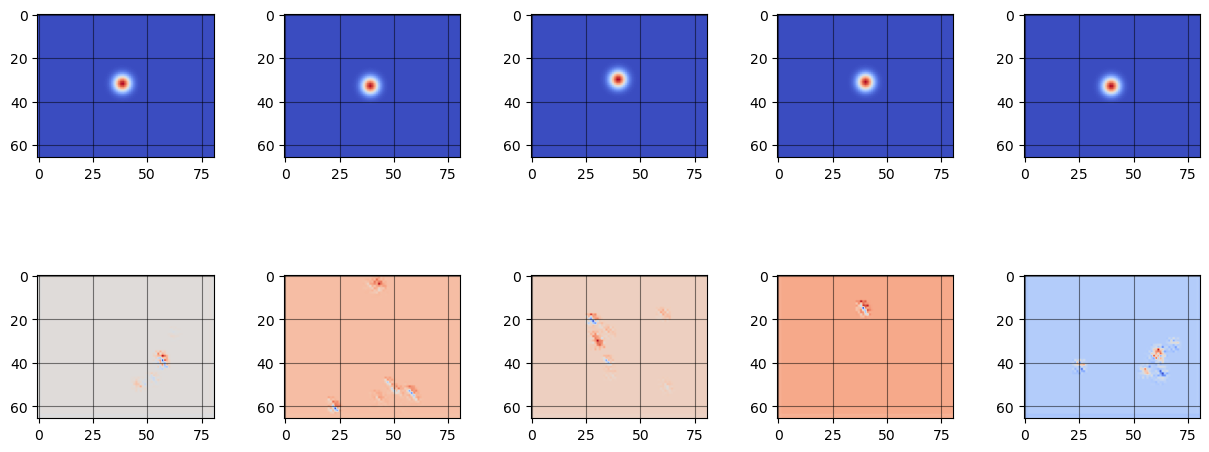

0.0007283313
sigma = 1.93724
22
	0.00076
	0.00072
	0.00074
	0.00080
	0.00076
	0.00066
	0.00069
	0.00070
	0.00073
	0.00070


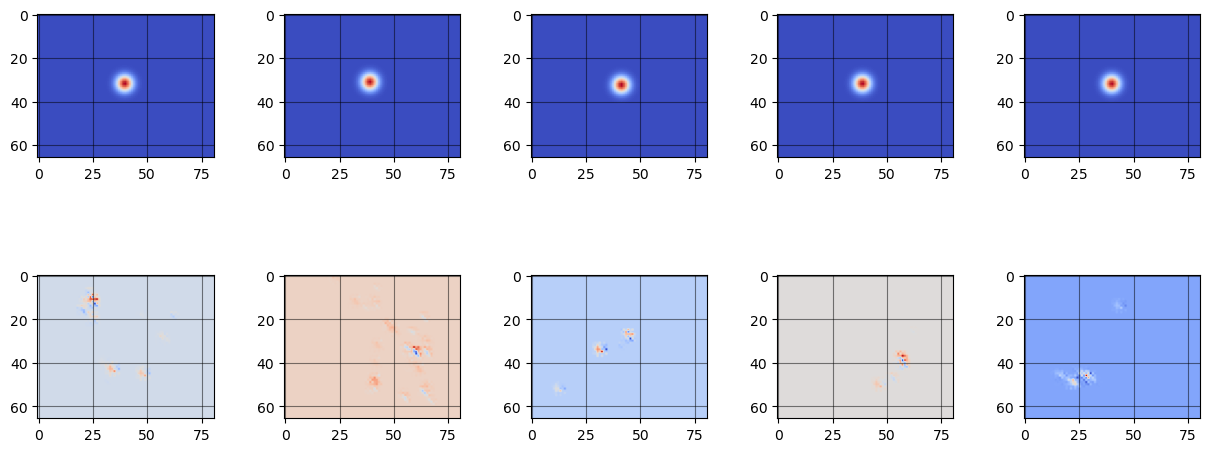

0.00072635675
sigma = 1.93455
23
	0.00082
	0.00067
	0.00081
	0.00070
	0.00067
	0.00069
	0.00072
	0.00070
	0.00072
	0.00073


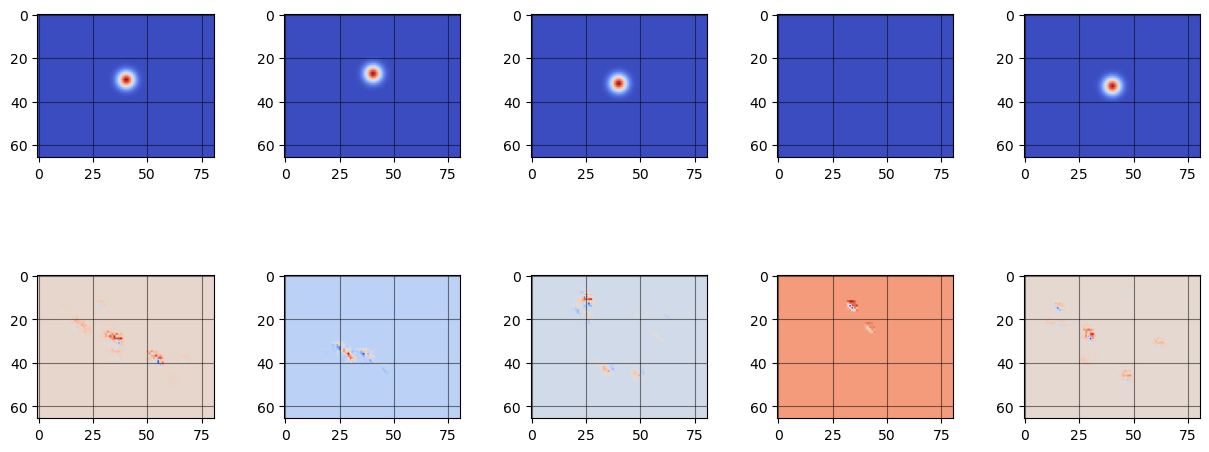

0.00072338234
sigma = 1.93187
24
	0.00070
	0.00070
	0.00071
	0.00076
	0.00066
	0.00072
	0.00076
	0.00073
	0.00079
	0.00069


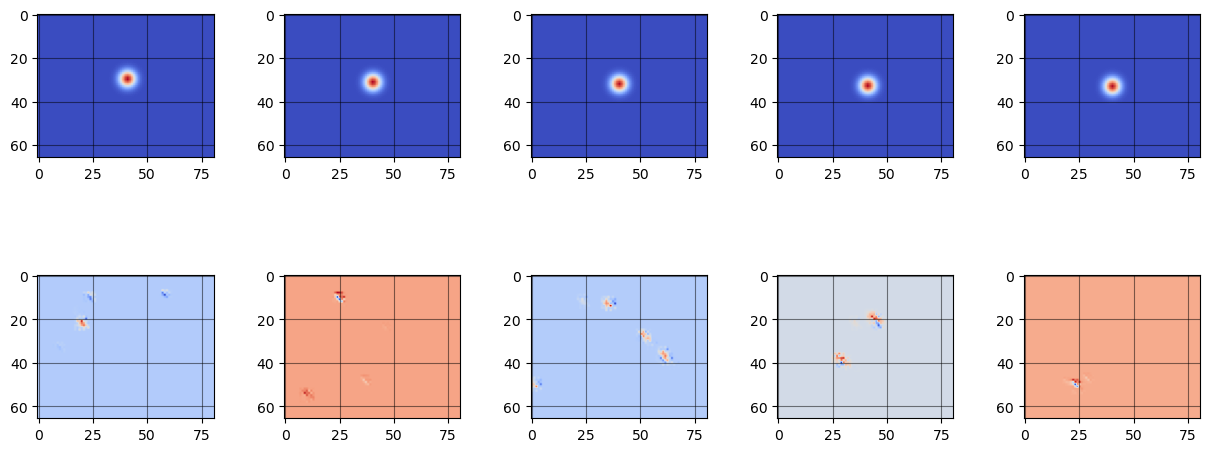

0.0007221488
sigma = 1.92920
25
	0.00073
	0.00076
	0.00064
	0.00063
	0.00078
	0.00079
	0.00069
	0.00074
	0.00077
	0.00066


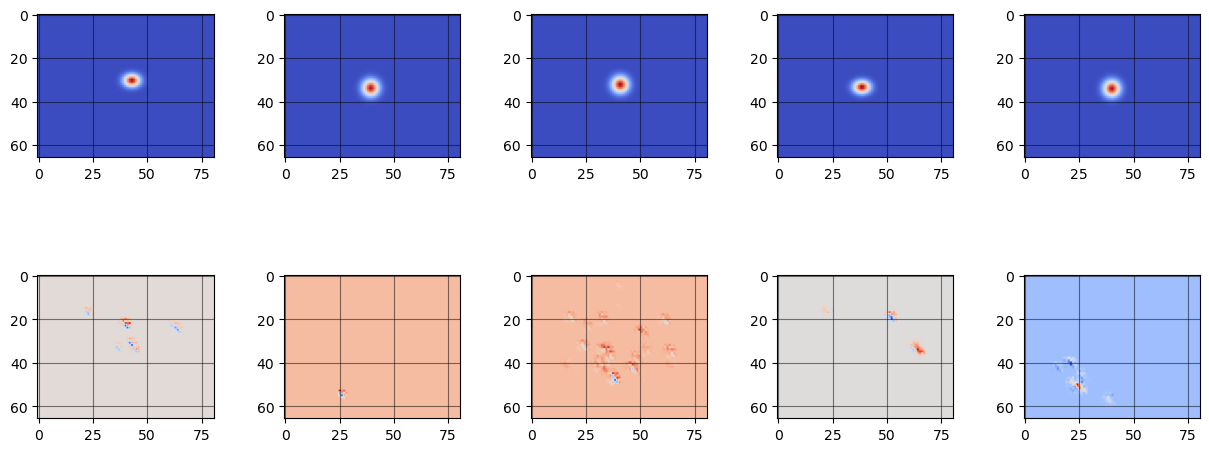

0.00071954203
sigma = 1.92652
26
	0.00068
	0.00068
	0.00069
	0.00073
	0.00076
	0.00074
	0.00069
	0.00068
	0.00073
	0.00080


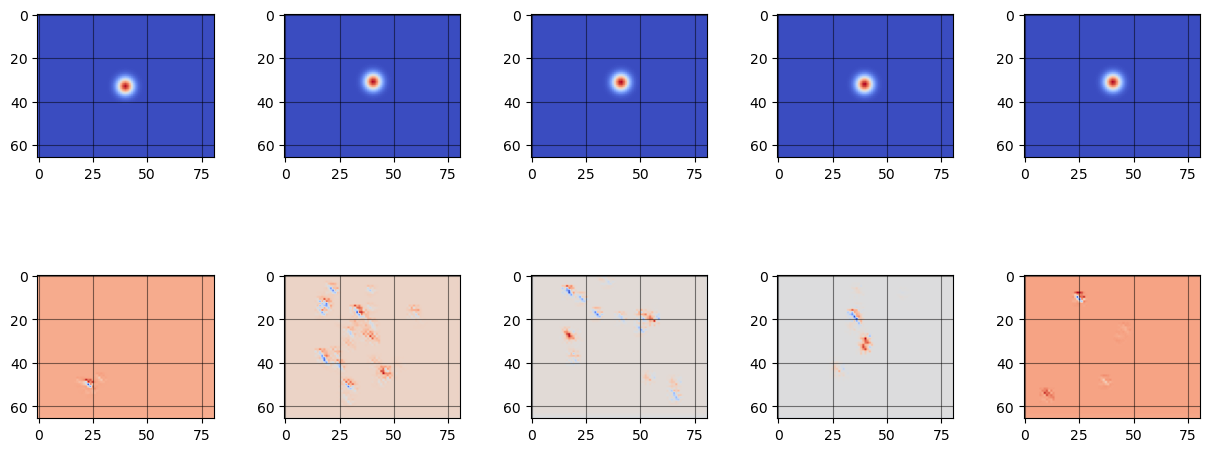

0.0007177434
sigma = 1.92385
27
	0.00069
	0.00068
	0.00068
	0.00081
	0.00076
	0.00071
	0.00071
	0.00066
	0.00070
	0.00074


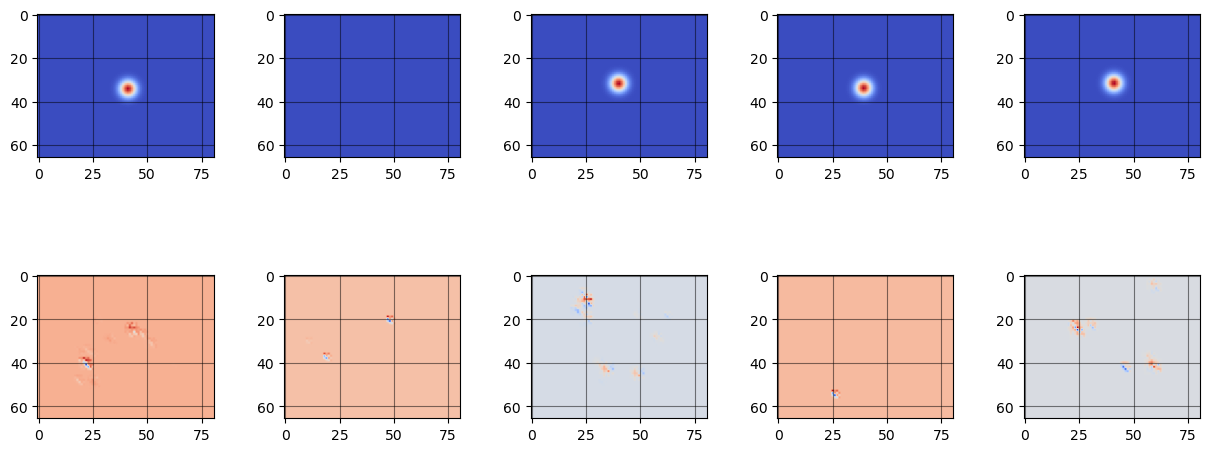

0.0007153699
sigma = 1.92119
28
	0.00069
	0.00066
	0.00066
	0.00070
	0.00075
	0.00072
	0.00077
	0.00064
	0.00075
	0.00077


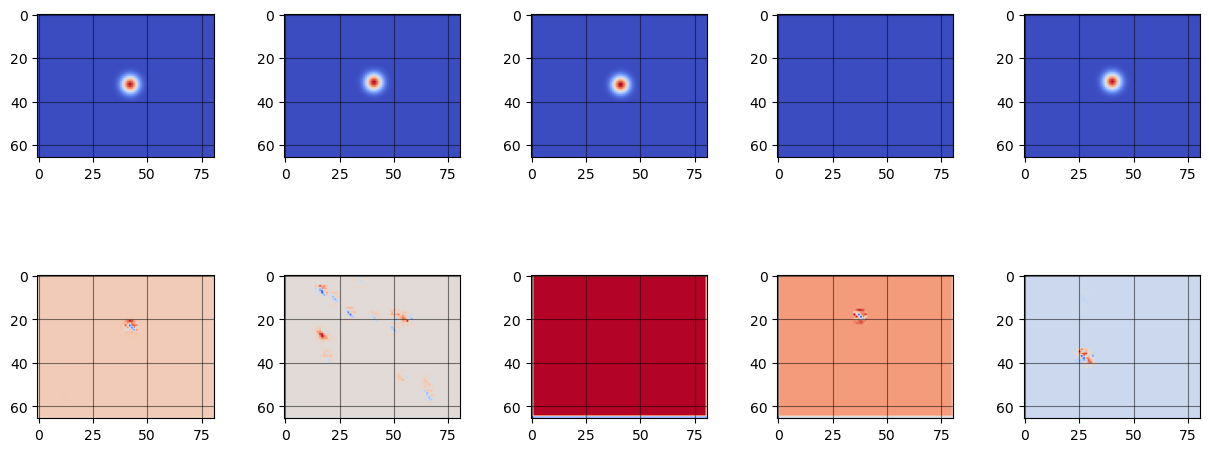

0.0007130475
sigma = 1.91853
29
	0.00069
	0.00068
	0.00062
	0.00069
	0.00074
	0.00075
	0.00078
	0.00076
	0.00069
	0.00070


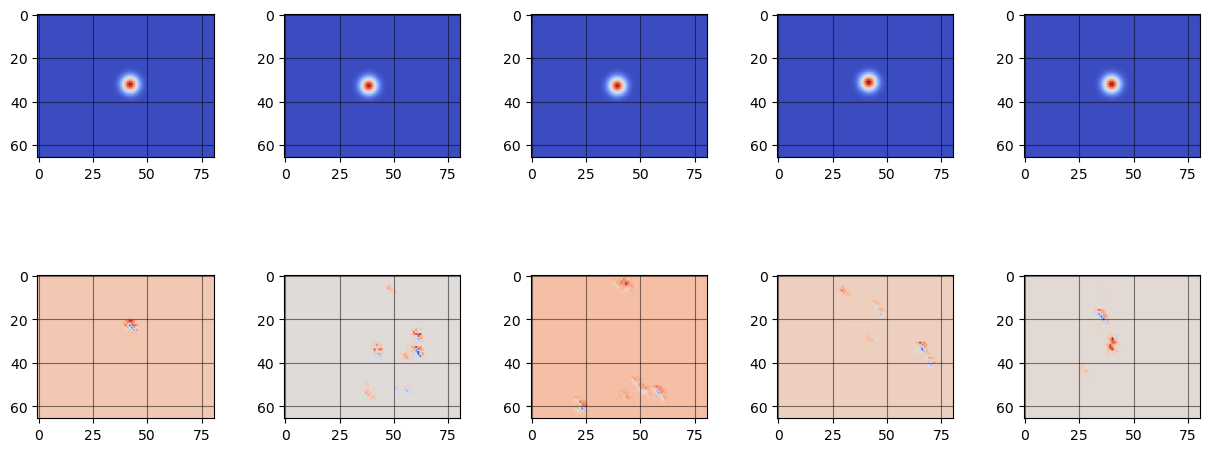

0.0007107518
sigma = 1.91587
30
	0.00075
	0.00065
	0.00073
	0.00068
	0.00076
	0.00072
	0.00071
	0.00071
	0.00064
	0.00073


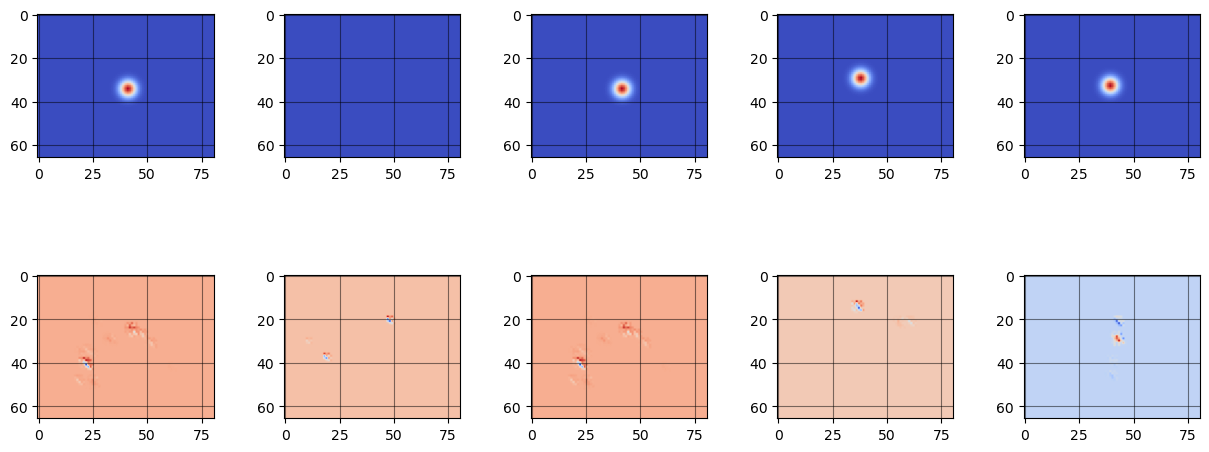

0.0007078656
sigma = 1.91322
31
	0.00063
	0.00066
	0.00072
	0.00069
	0.00071
	0.00071
	0.00065
	0.00078
	0.00078
	0.00073


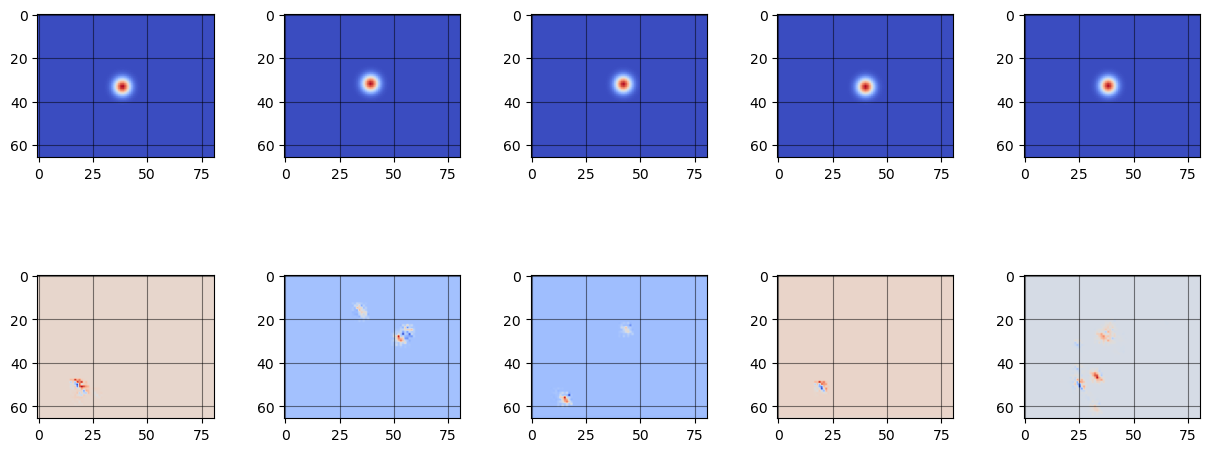

0.0007068678
sigma = 1.91057
32
	0.00070
	0.00074
	0.00065
	0.00064
	0.00071
	0.00069
	0.00069
	0.00073
	0.00076
	0.00074


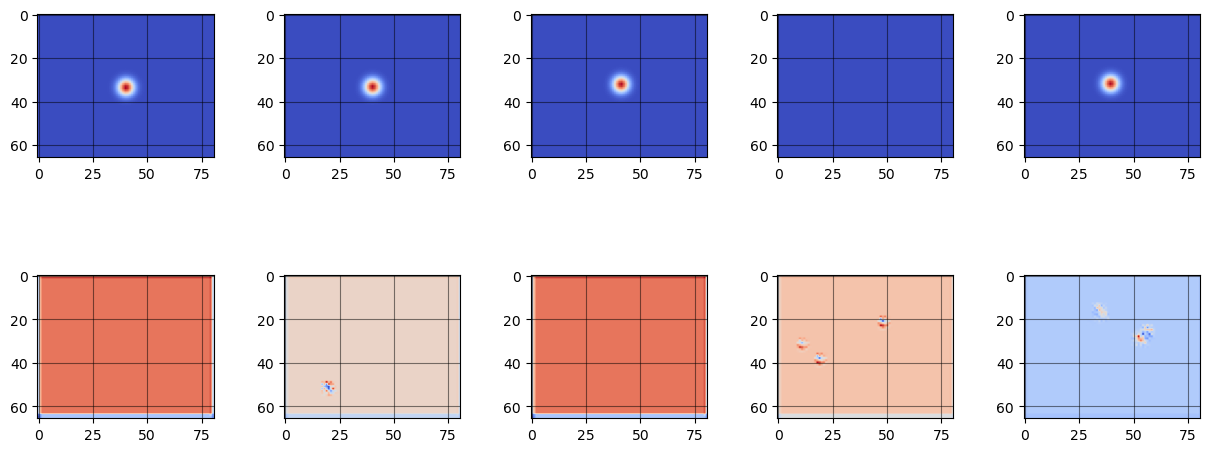

0.00070396194
sigma = 1.90792
33
	0.00065
	0.00079
	0.00075
	0.00068
	0.00066
	0.00067
	0.00072
	0.00071
	0.00073
	0.00065


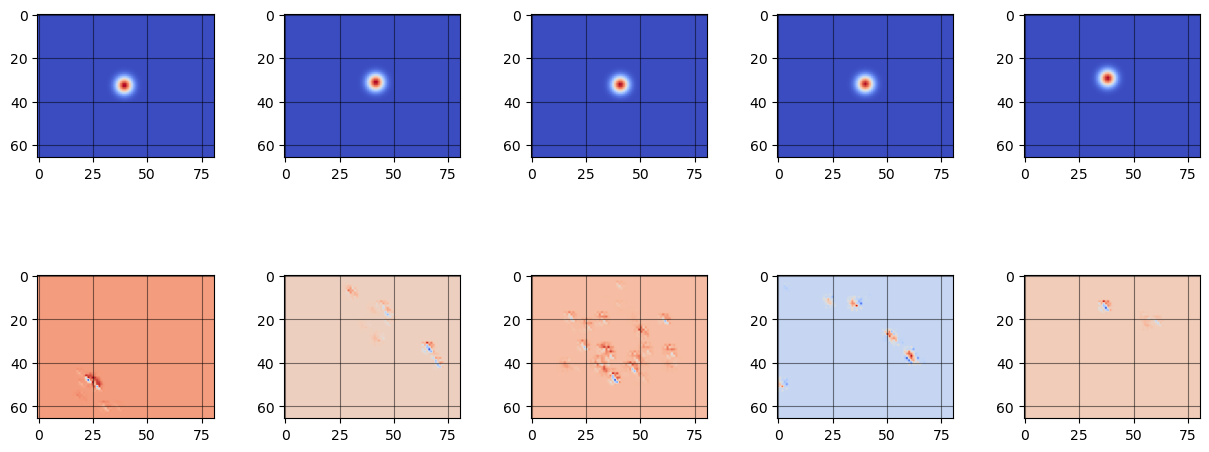

0.000702159
sigma = 1.90528
34
	0.00064
	0.00069
	0.00068
	0.00074
	0.00065
	0.00069
	0.00078
	0.00070
	0.00075
	0.00068


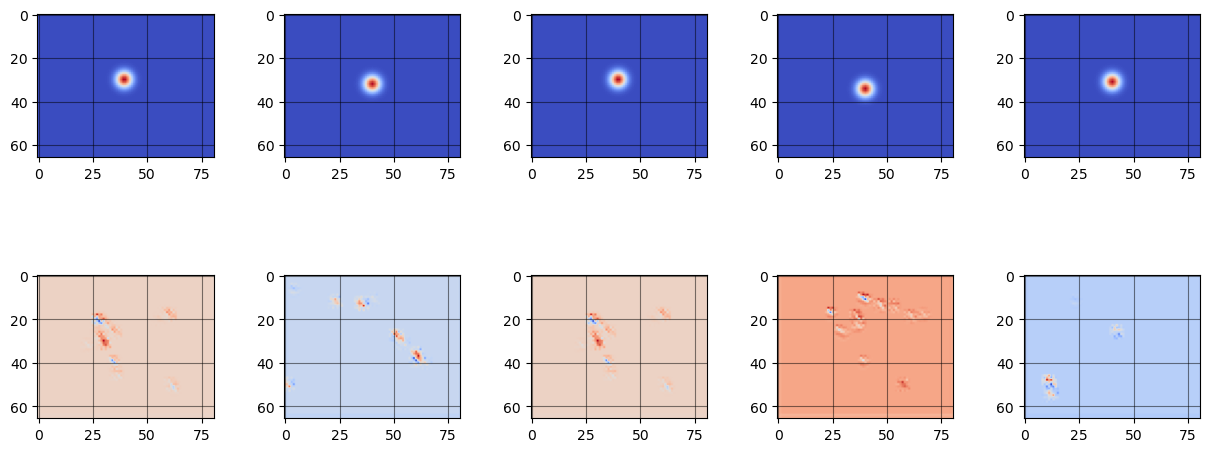

0.00070012006
sigma = 1.90264
35
	0.00070
	0.00066
	0.00069
	0.00075
	0.00068
	0.00061
	0.00077
	0.00074
	0.00068
	0.00069


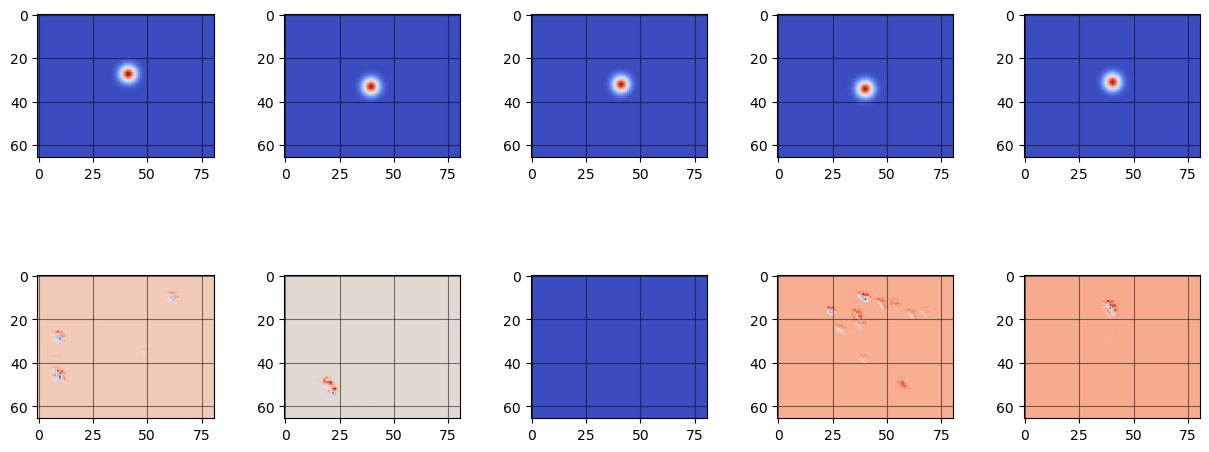

0.0006973356
sigma = 1.90000
36
	0.00070
	0.00065
	0.00067
	0.00068
	0.00073
	0.00066
	0.00069
	0.00066
	0.00079
	0.00073


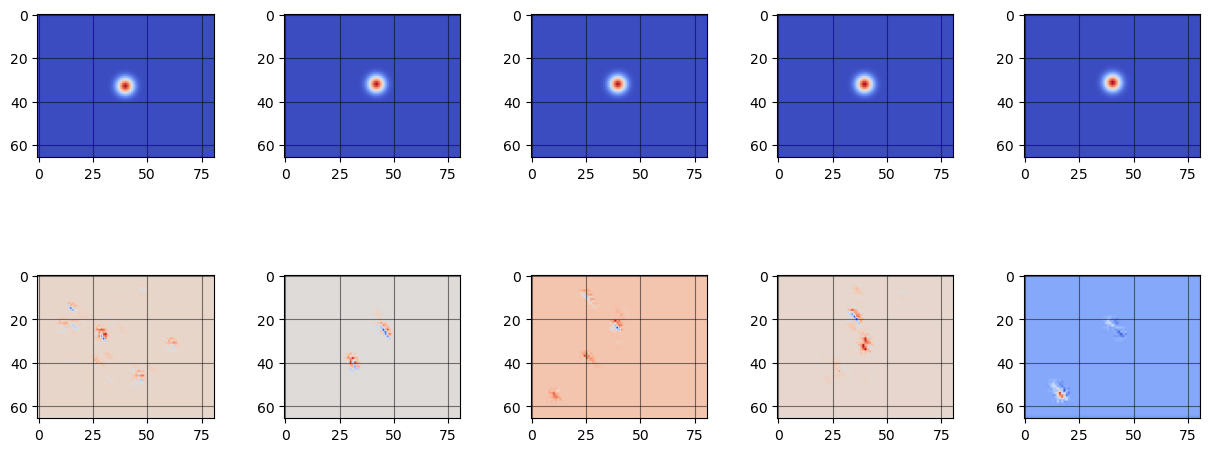

0.0006951199
sigma = 1.89737
37
	0.00070
	0.00076
	0.00071
	0.00064
	0.00067
	0.00073
	0.00066
	0.00065
	0.00074
	0.00067


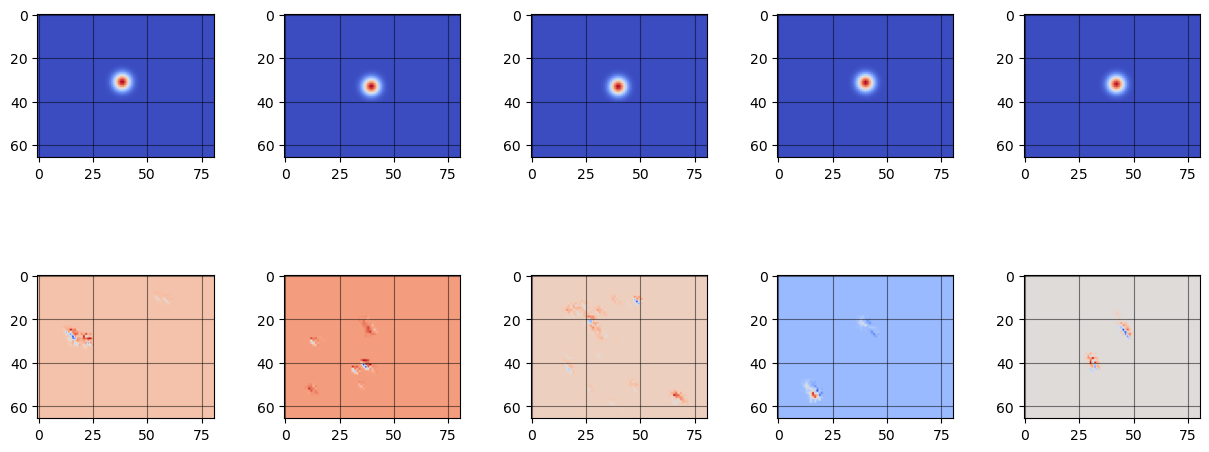

0.00069288653
sigma = 1.89474
38
	0.00068
	0.00076
	0.00072
	0.00062
	0.00066
	0.00073
	0.00065
	0.00068
	0.00078
	0.00063


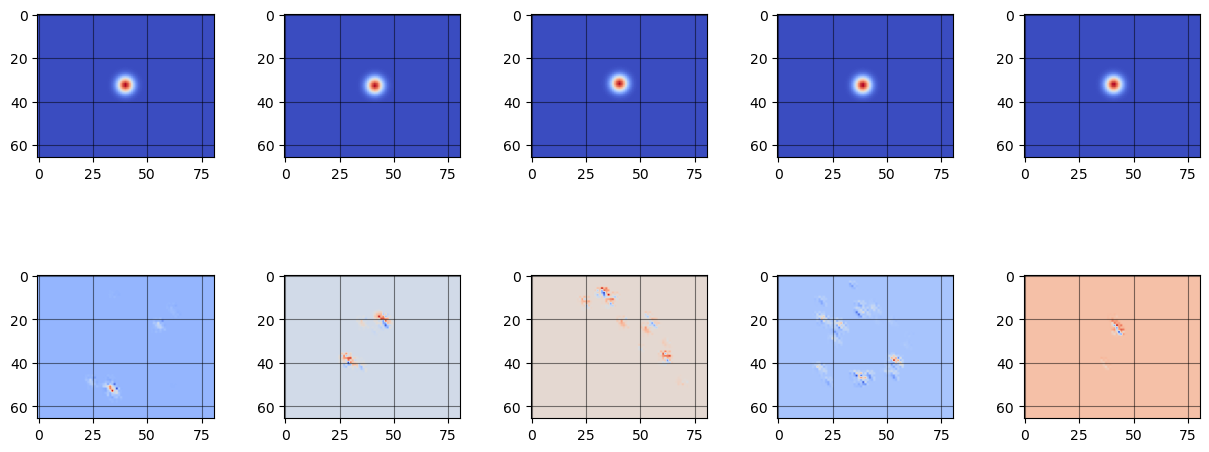

0.0006909588
sigma = 1.89212
39
	0.00067
	0.00069
	0.00071
	0.00070
	0.00068
	0.00067
	0.00067
	0.00071
	0.00072
	0.00067


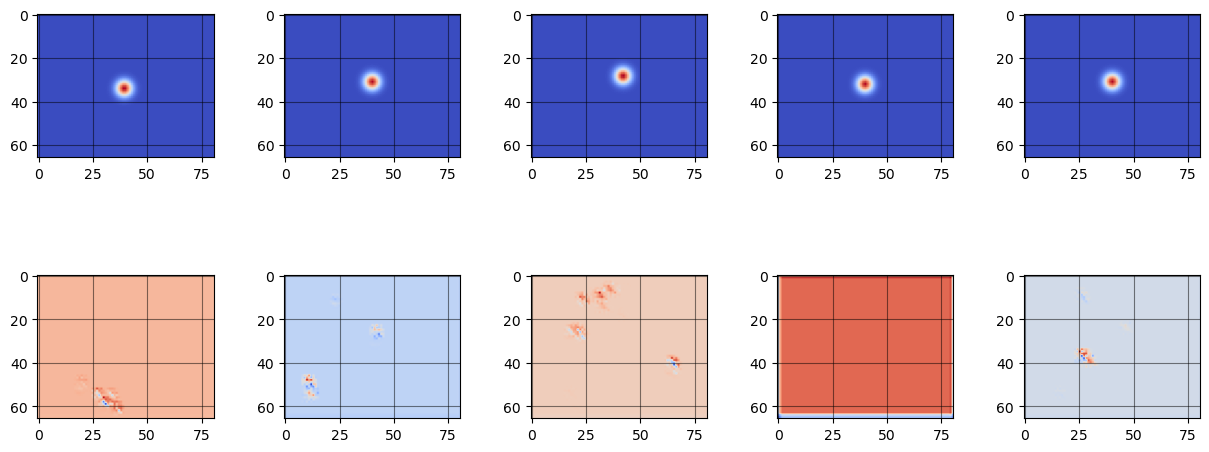

0.0006889825
sigma = 1.88949
40
	0.00067
	0.00071
	0.00071
	0.00066
	0.00074
	0.00067
	0.00069
	0.00063
	0.00072
	0.00068


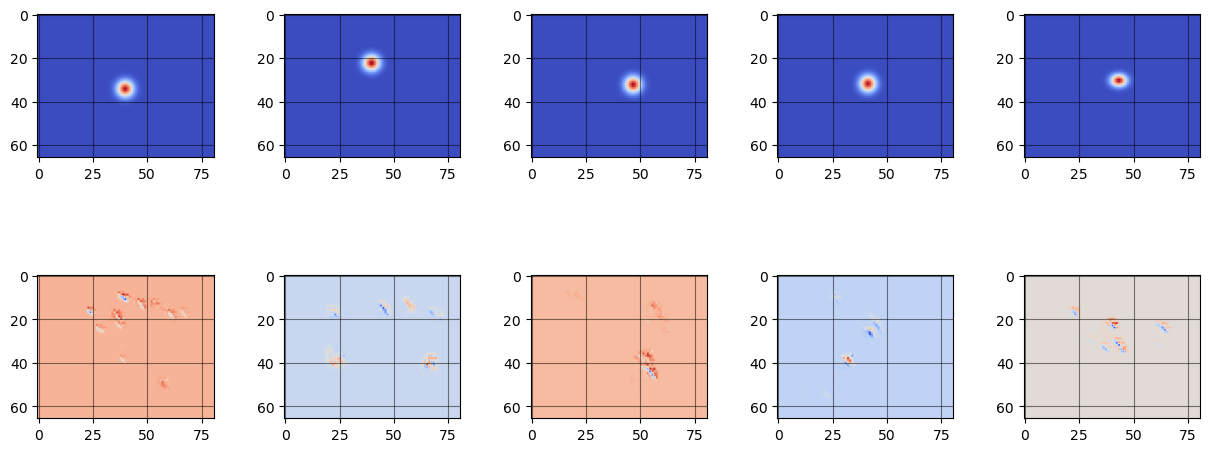

0.000686814
sigma = 1.88688
41
	0.00063
	0.00071
	0.00072
	0.00072
	0.00069
	0.00065
	0.00064
	0.00077
	0.00068
	0.00065


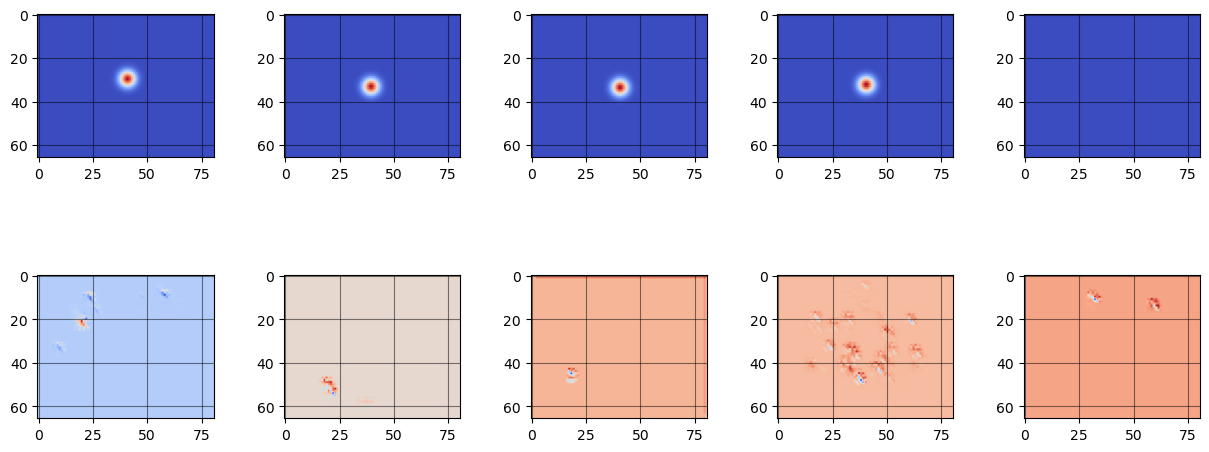

0.00068513816
sigma = 1.88426
42
	0.00077
	0.00064
	0.00066
	0.00076
	0.00064
	0.00068
	0.00078
	0.00058
	0.00063
	0.00070


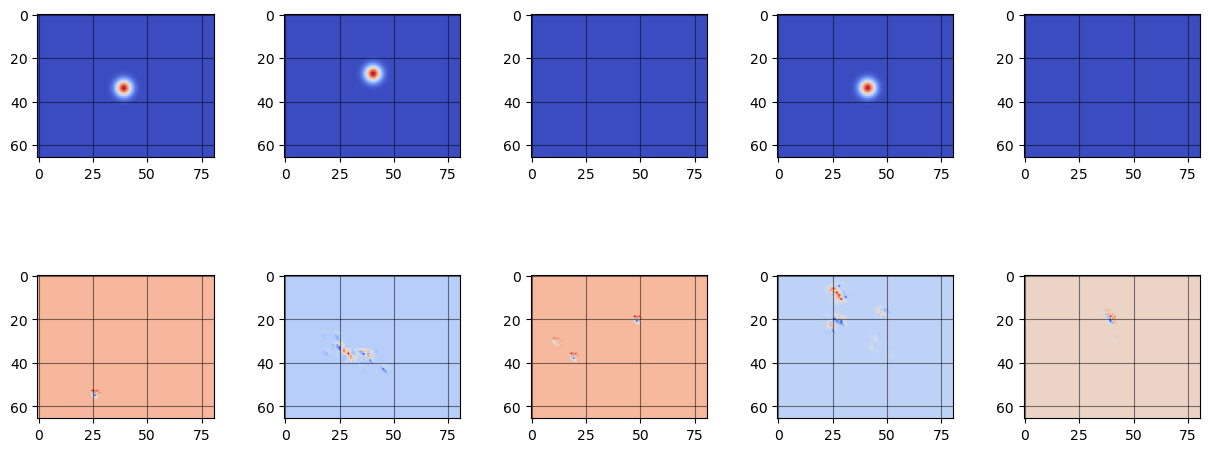

0.0006816791
sigma = 1.88165
43
	0.00069
	0.00079
	0.00064
	0.00072
	0.00065
	0.00067
	0.00069
	0.00065
	0.00065
	0.00066


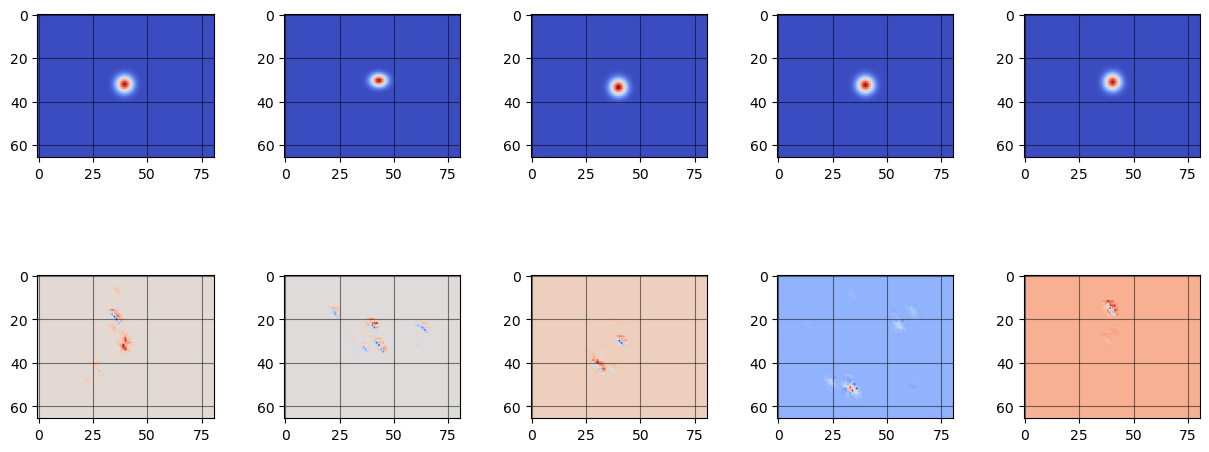

0.0006803765
sigma = 1.87905
44
	0.00064
	0.00071
	0.00066
	0.00071
	0.00060
	0.00069
	0.00074
	0.00068
	0.00067
	0.00070


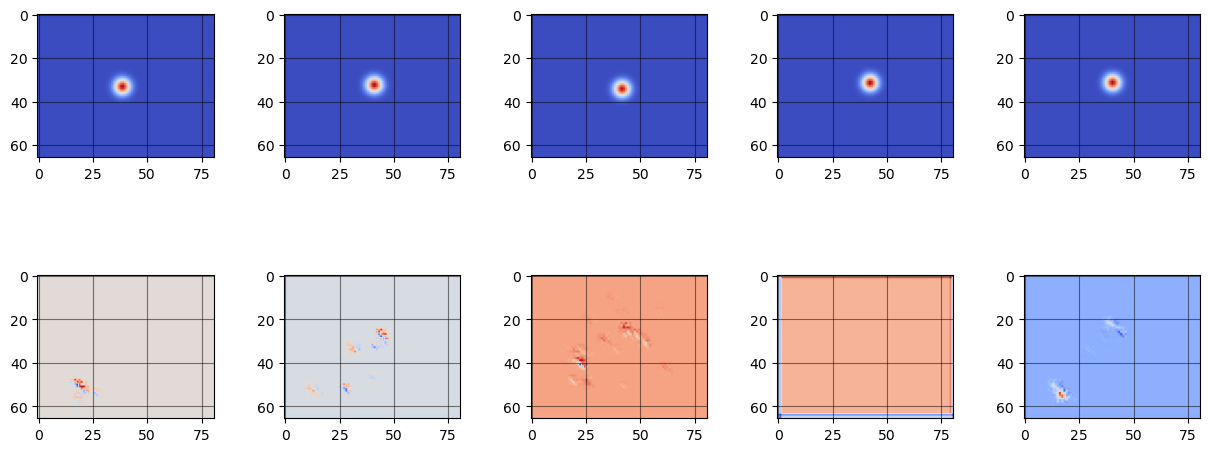

0.00067878707
sigma = 1.87644
45
	0.00066
	0.00074
	0.00067
	0.00065
	0.00070
	0.00067
	0.00066
	0.00070
	0.00066
	0.00066


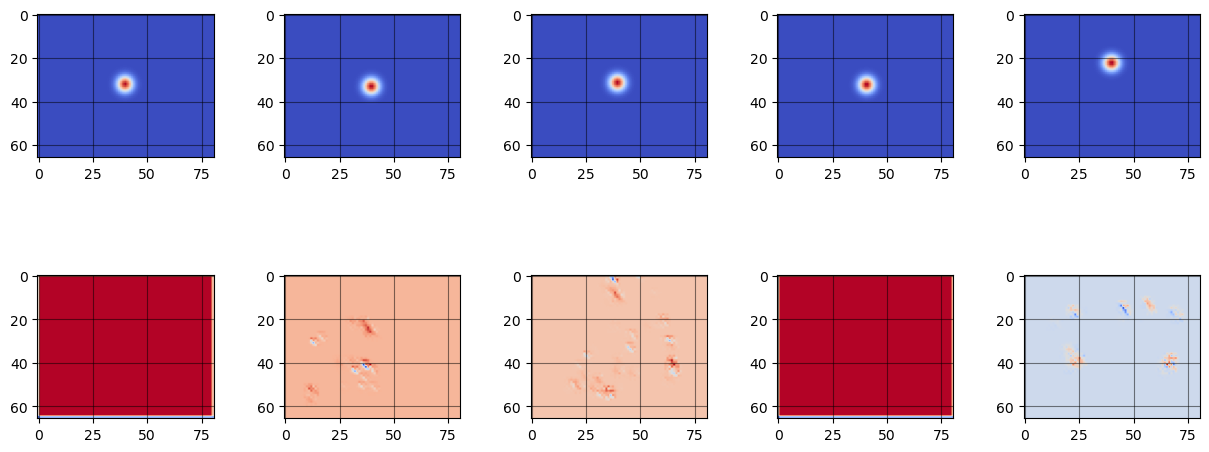

0.00067649706
sigma = 1.87384
46
	0.00067
	0.00071
	0.00066
	0.00074
	0.00061
	0.00068
	0.00067
	0.00064
	0.00063
	0.00074


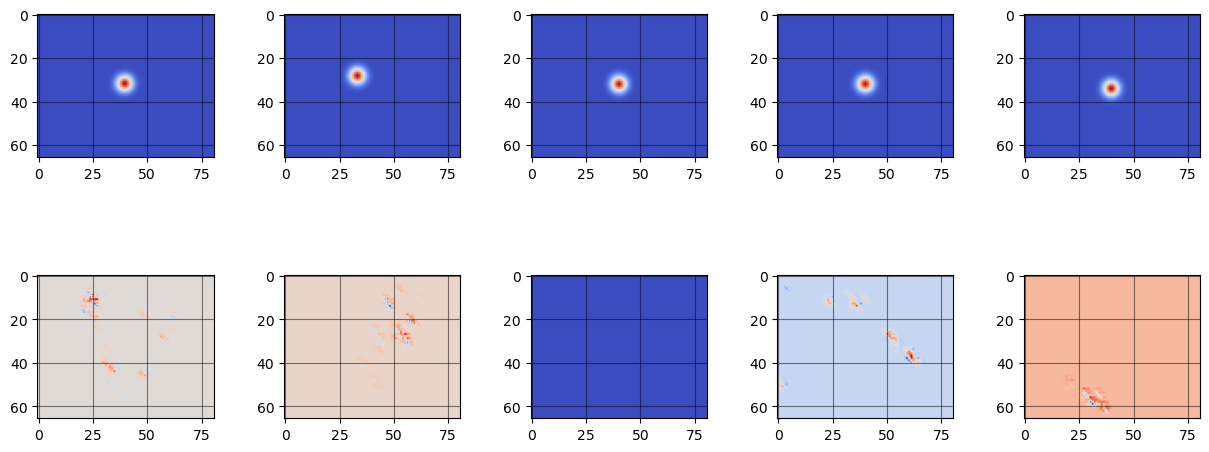

0.00067437947
sigma = 1.87125
47
	0.00066
	0.00068
	0.00070
	0.00059
	0.00072
	0.00069
	0.00069
	0.00066
	0.00063
	0.00072


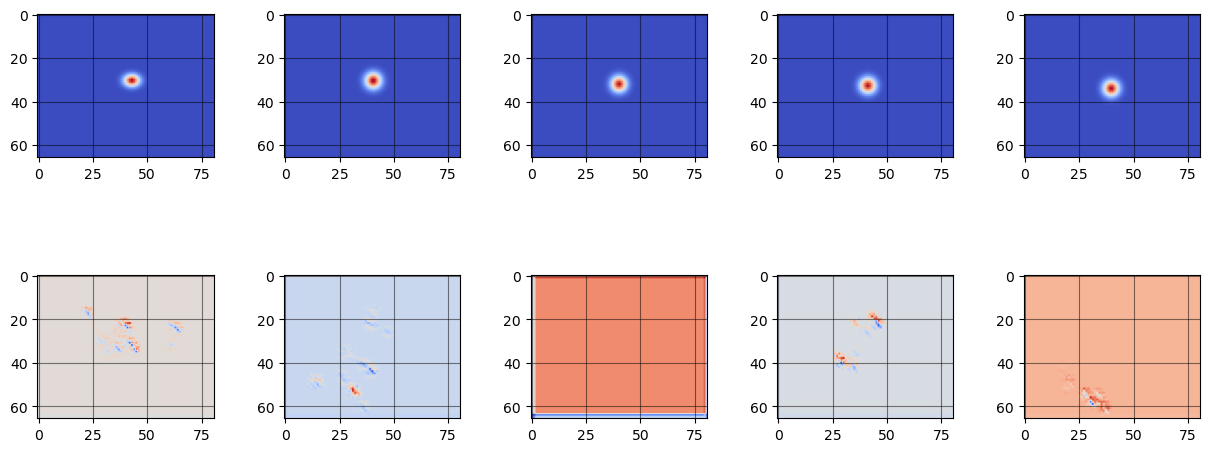

0.00067243376
sigma = 1.86865
48
	0.00073
	0.00065
	0.00062
	0.00066
	0.00067
	0.00064
	0.00066
	0.00070
	0.00070
	0.00066


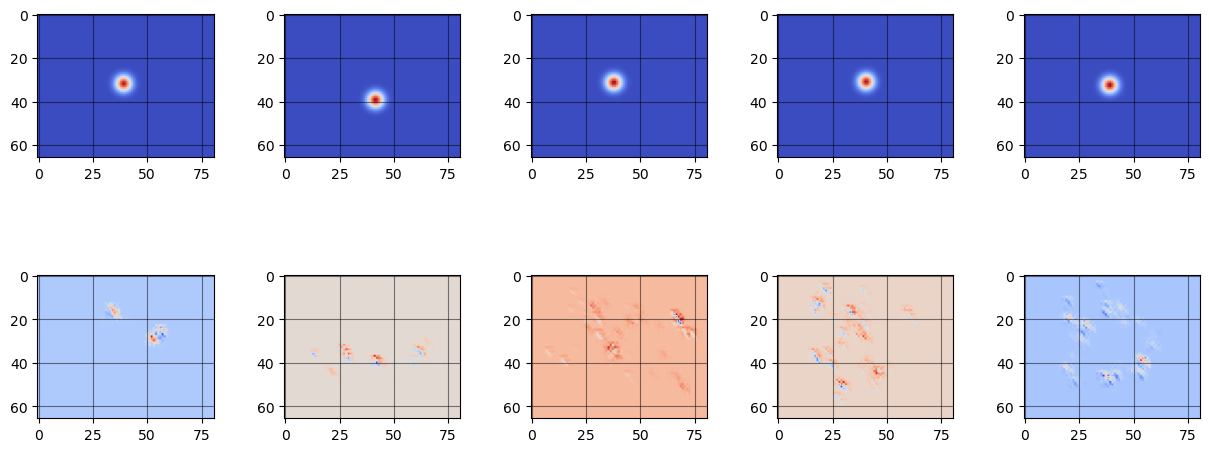

0.0006696769
sigma = 1.86607
49
	0.00070
	0.00064
	0.00066
	0.00066
	0.00068
	0.00065
	0.00062
	0.00075
	0.00065
	0.00068


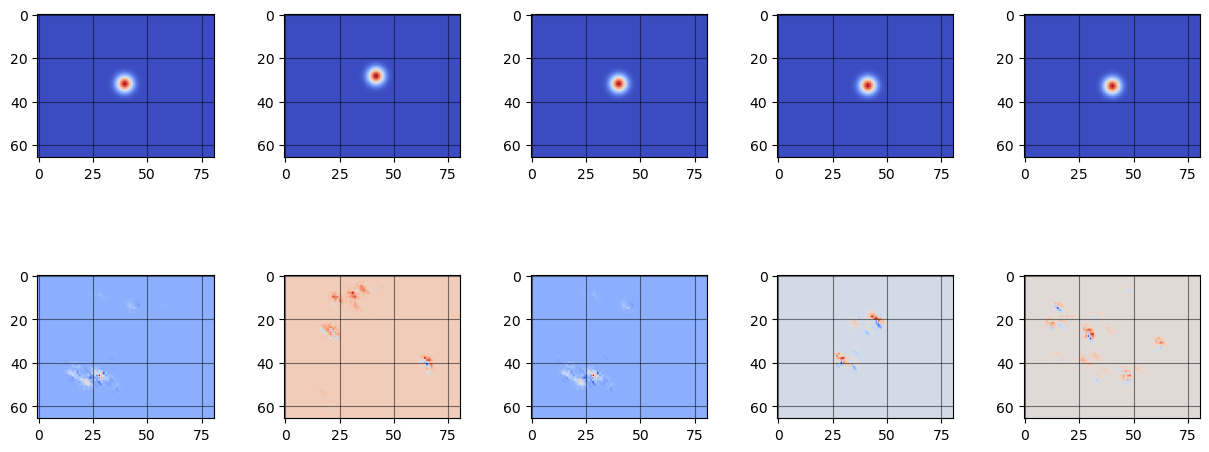

0.00066797616
sigma = 1.86348
50
	0.00069
	0.00067
	0.00067
	0.00064
	0.00068
	0.00063
	0.00069
	0.00066
	0.00066
	0.00066


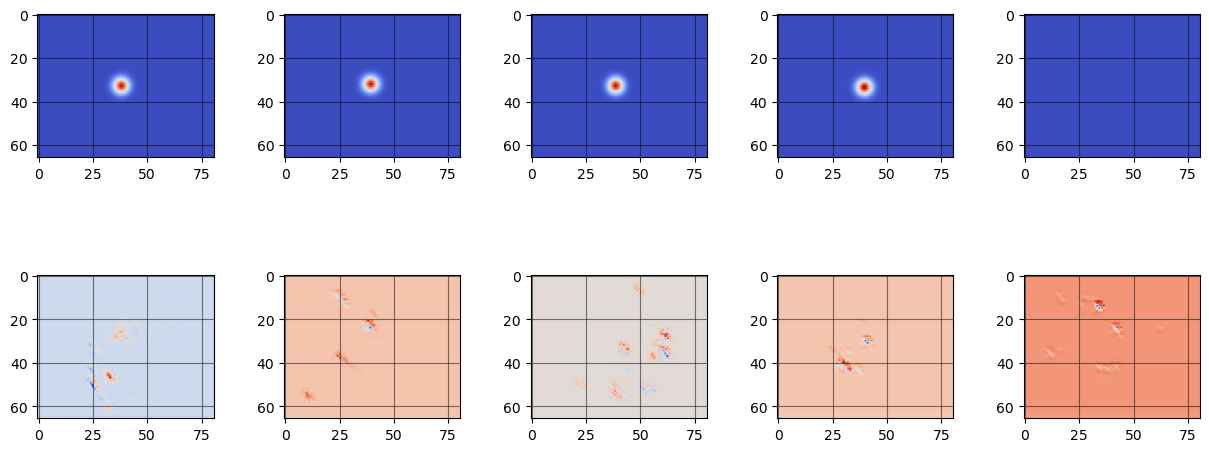

0.00066611625
sigma = 1.86090
51
	0.00060
	0.00065
	0.00065
	0.00068
	0.00068
	0.00066
	0.00071
	0.00067
	0.00065
	0.00069


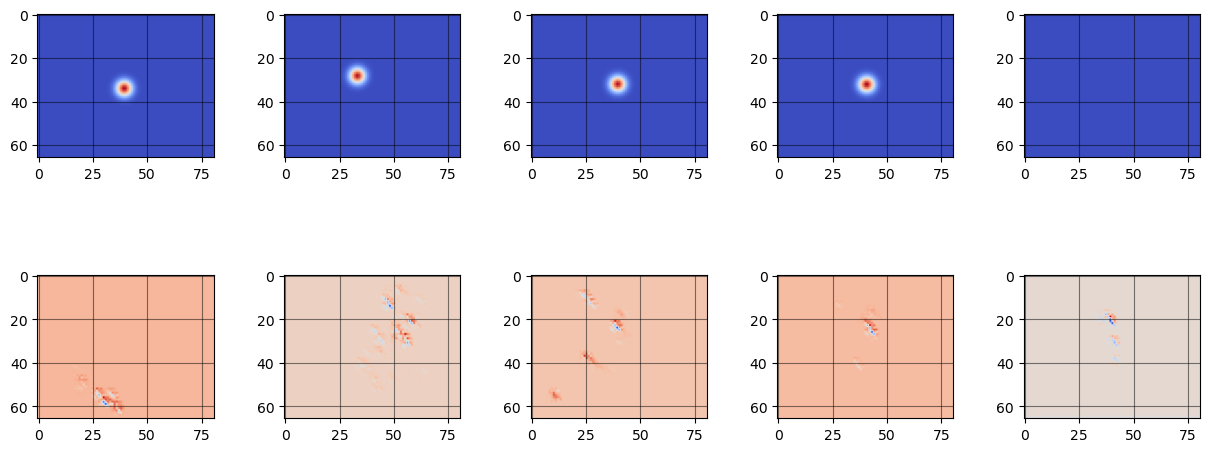

0.0006650271
sigma = 1.85832
52
	0.00069
	0.00069
	0.00069
	0.00065
	0.00065
	0.00066
	0.00066
	0.00061
	0.00068
	0.00065


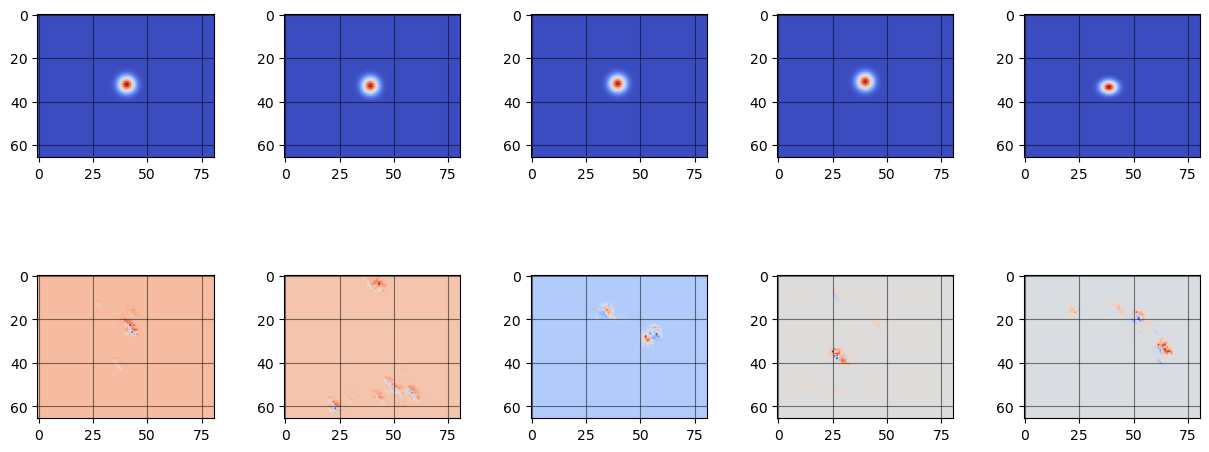

0.00066220167
sigma = 1.85575
53
	0.00068
	0.00067
	0.00069
	0.00064
	0.00062
	0.00068
	0.00062
	0.00066
	0.00063
	0.00071


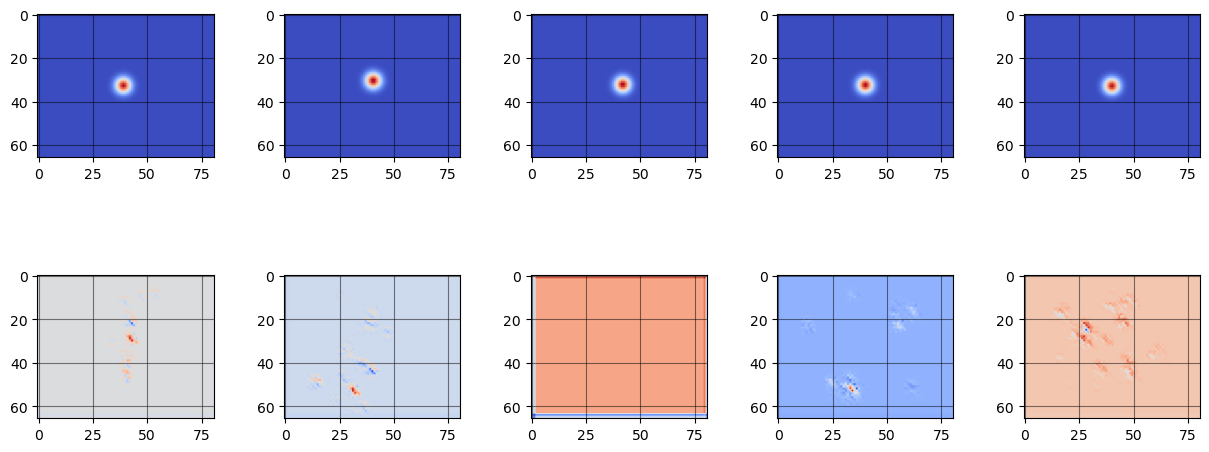

0.00066032953
sigma = 1.85318
54
	0.00066
	0.00062
	0.00062
	0.00065
	0.00061
	0.00071
	0.00071
	0.00064
	0.00069
	0.00067


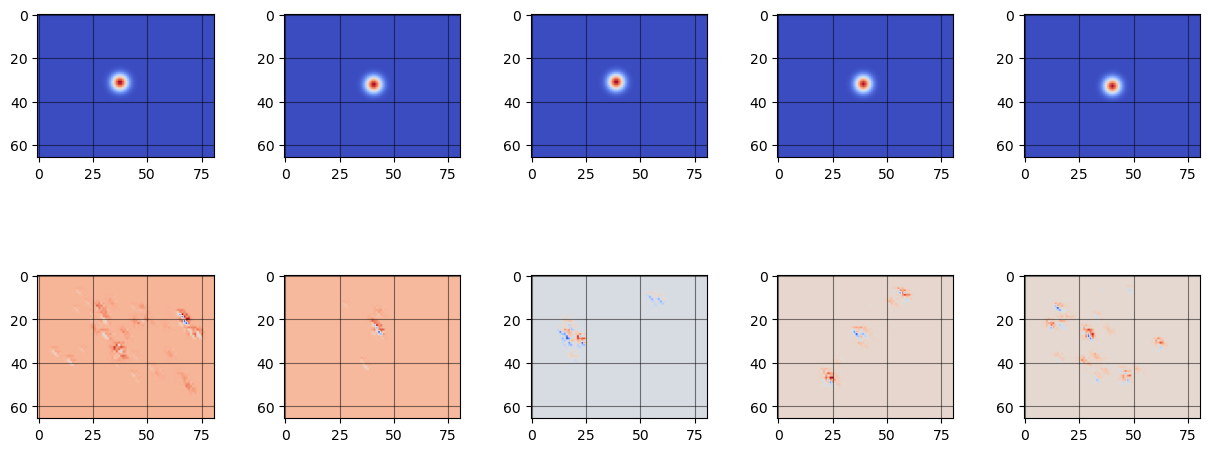

0.0006586297
sigma = 1.85061
55
	0.00067
	0.00063
	0.00067
	0.00066
	0.00064
	0.00067
	0.00065
	0.00065
	0.00072
	0.00061


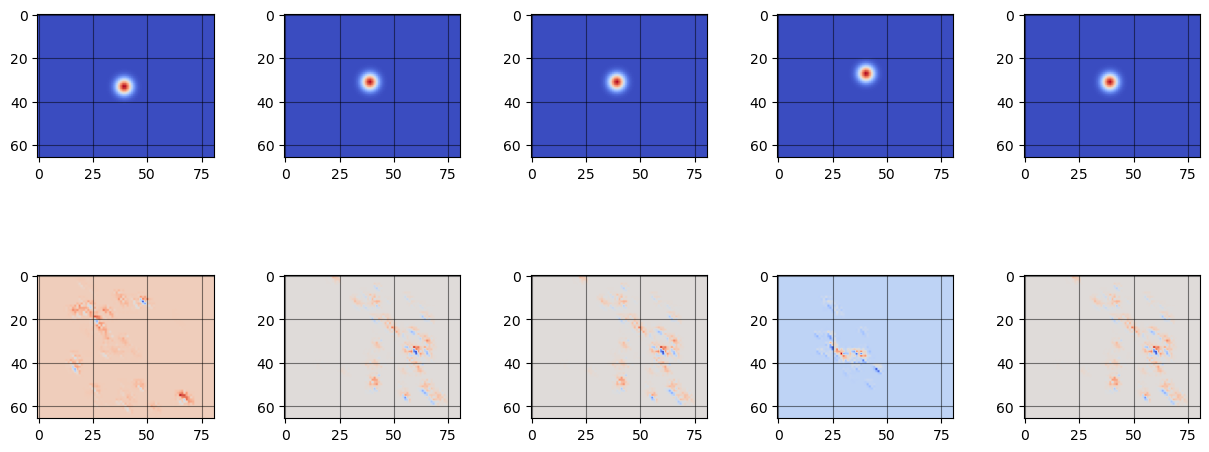

0.00065662223
sigma = 1.84805
56
	0.00064
	0.00061
	0.00069
	0.00067
	0.00067
	0.00065
	0.00066
	0.00066
	0.00067
	0.00063


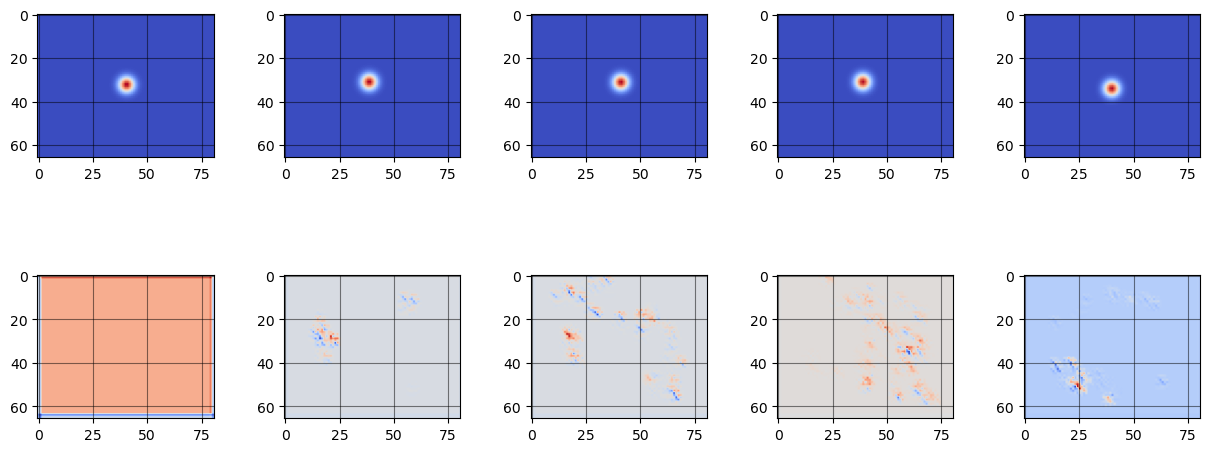

0.0006549922
sigma = 1.84548
57
	0.00069
	0.00065
	0.00058
	0.00062
	0.00064
	0.00068
	0.00066
	0.00065
	0.00069
	0.00067


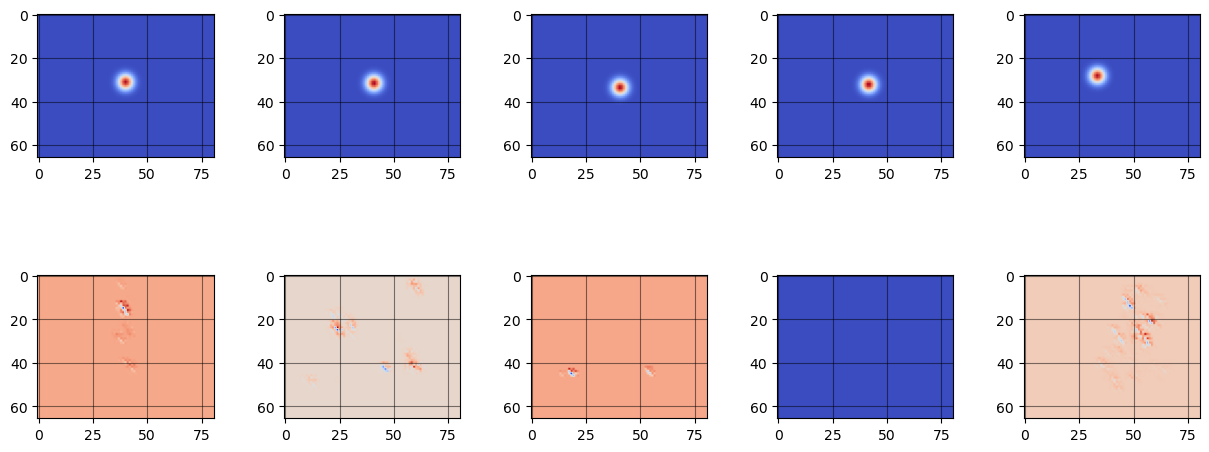

0.00065257476
sigma = 1.84293
58
	0.00058
	0.00064
	0.00061
	0.00068
	0.00065
	0.00067
	0.00063
	0.00068
	0.00070
	0.00067


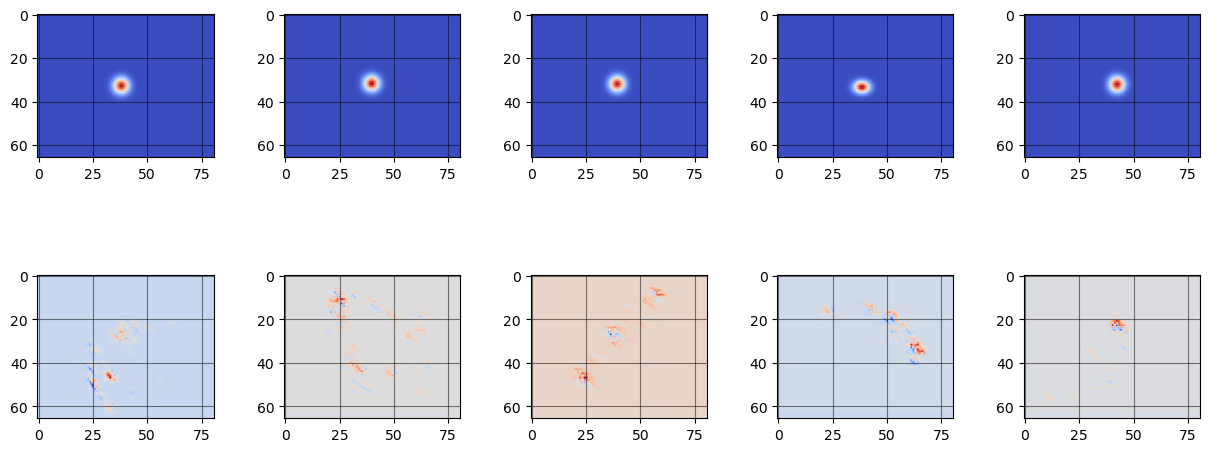

0.0006517394
sigma = 1.84038
59
	0.00072
	0.00063
	0.00064
	0.00062
	0.00066
	0.00068
	0.00062
	0.00068
	0.00060
	0.00062


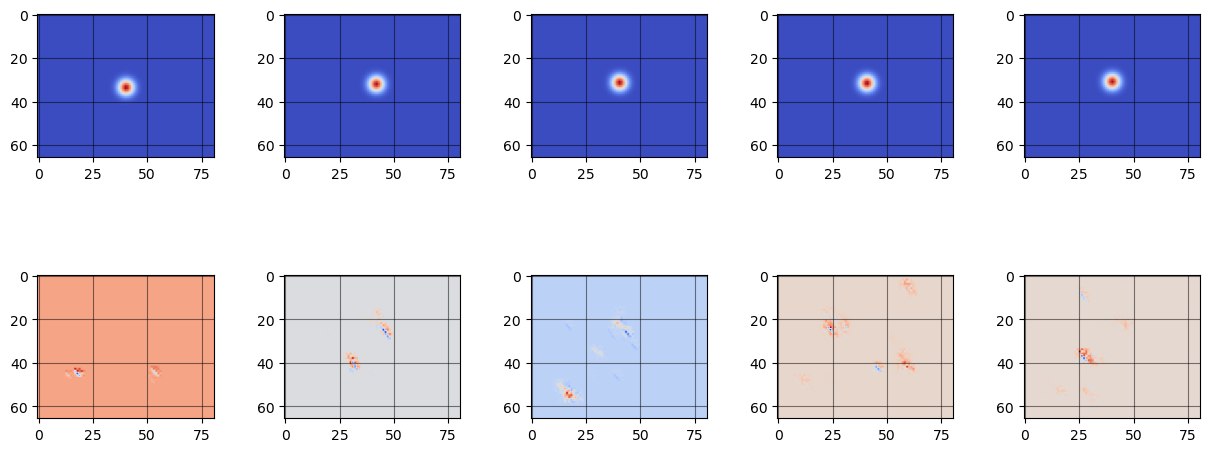

0.00064845727
sigma = 1.83783
60
	0.00063
	0.00061
	0.00062
	0.00068
	0.00062
	0.00067
	0.00069
	0.00069
	0.00061
	0.00065


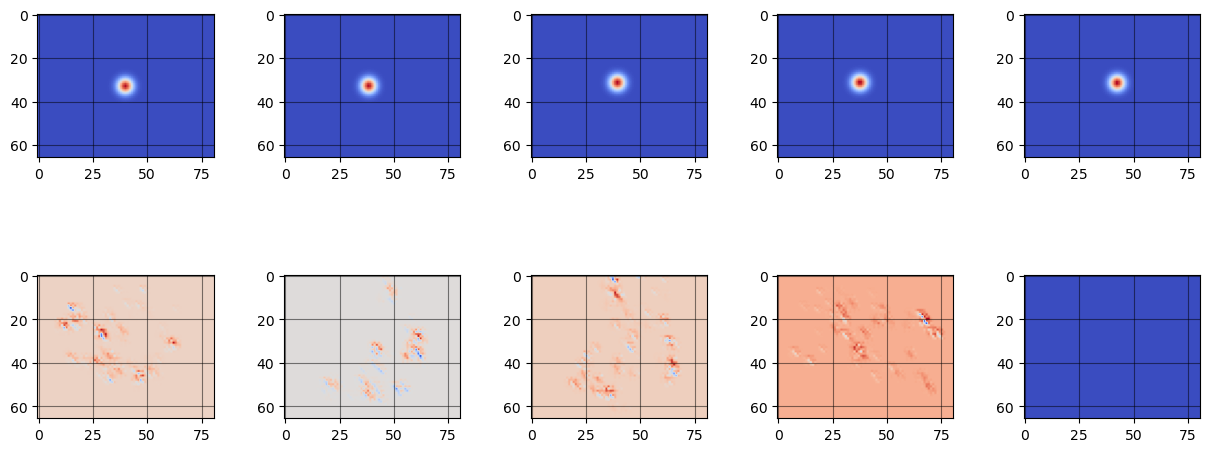

0.00064748817
sigma = 1.83528
61
	0.00066
	0.00060
	0.00074
	0.00061
	0.00062
	0.00070
	0.00058
	0.00066
	0.00063
	0.00064


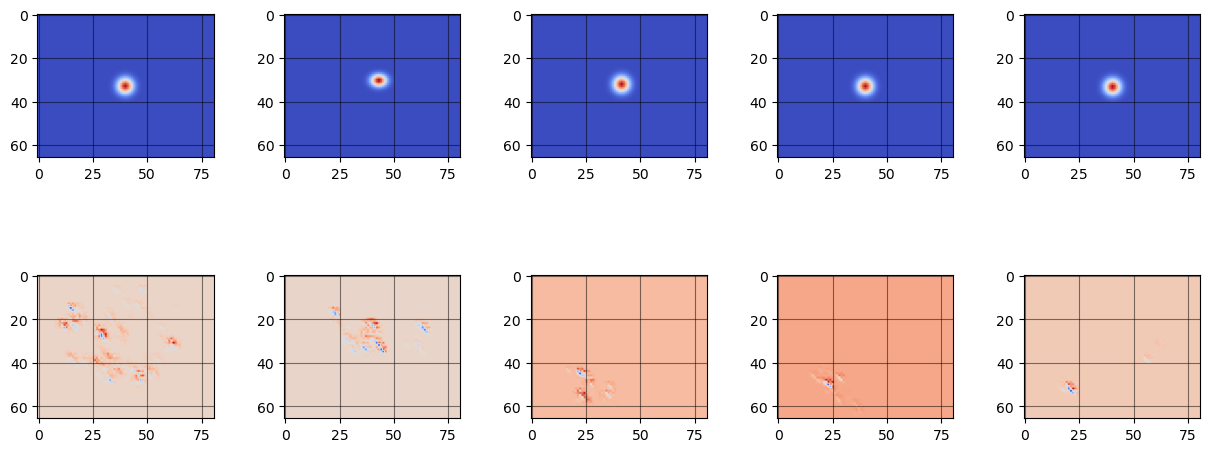

0.00064536196
sigma = 1.83274
62
	0.00067
	0.00066
	0.00063
	0.00066
	0.00063
	0.00066
	0.00062
	0.00058
	0.00069
	0.00064


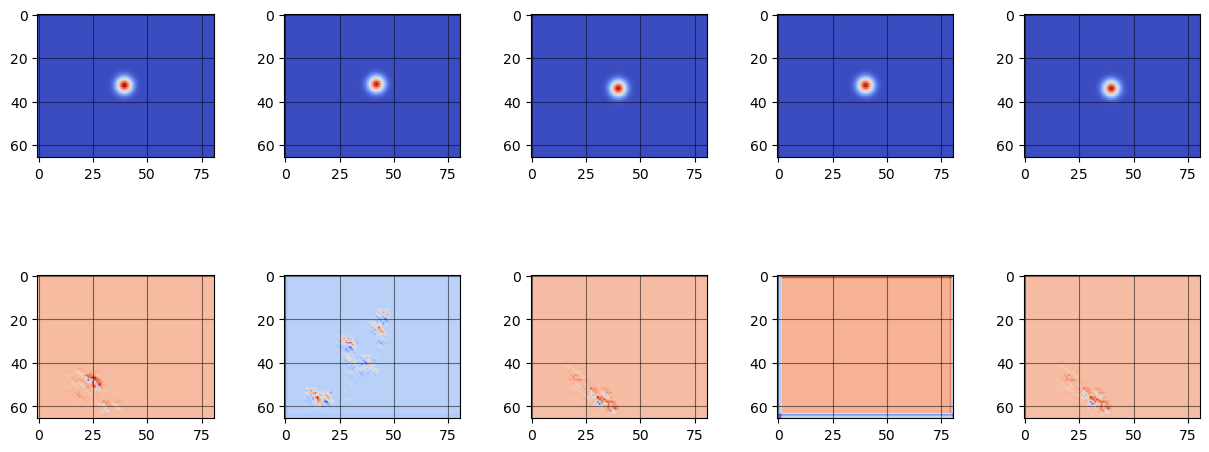

0.00064345804
sigma = 1.83020
63
	0.00072
	0.00059
	0.00060
	0.00063
	0.00067
	0.00057
	0.00065
	0.00065
	0.00070
	0.00063


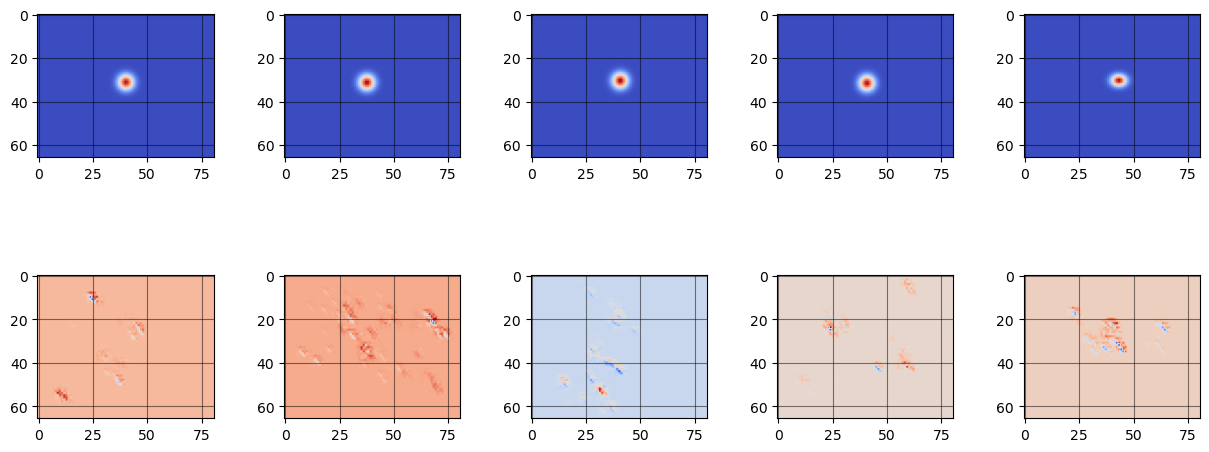

0.00064115005
sigma = 1.82766
64
	0.00064
	0.00068
	0.00061
	0.00059
	0.00066
	0.00063
	0.00065
	0.00067
	0.00065
	0.00062


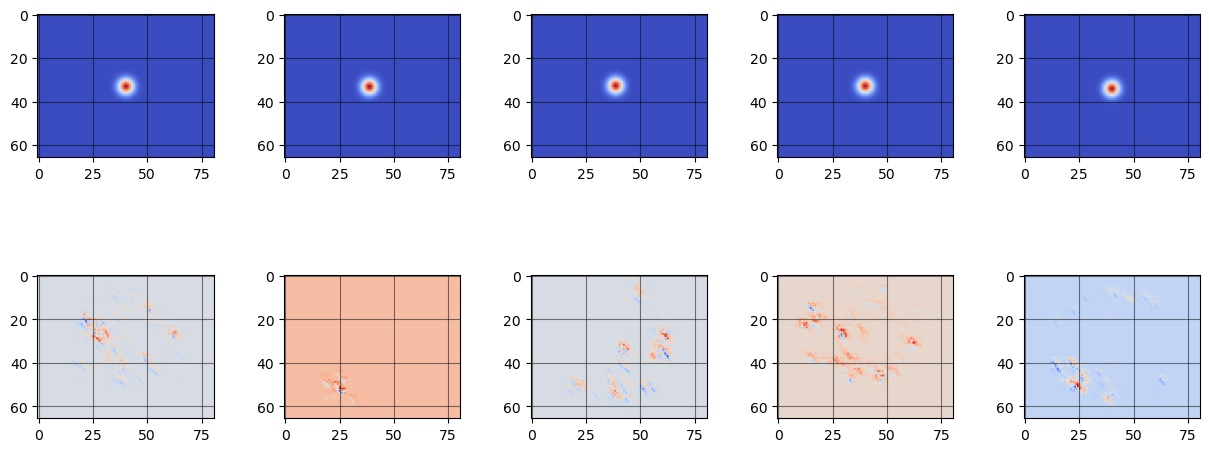

0.0006400537
sigma = 1.82513
65
	0.00067
	0.00065
	0.00066
	0.00060
	0.00065
	0.00068
	0.00060
	0.00061
	0.00064
	0.00062


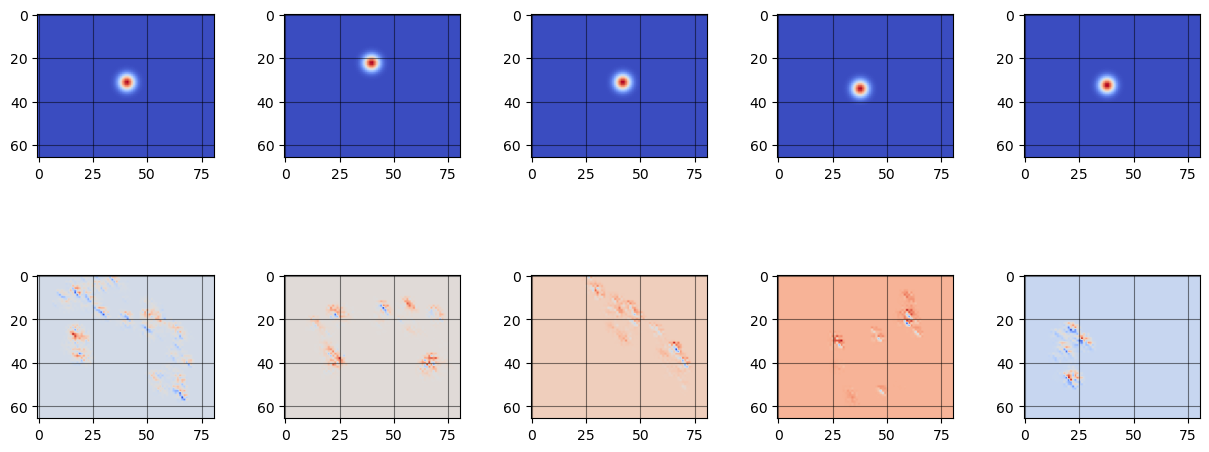

0.0006379739
sigma = 1.82260
66
	0.00062
	0.00067
	0.00064
	0.00059
	0.00067
	0.00064
	0.00064
	0.00066
	0.00061
	0.00064


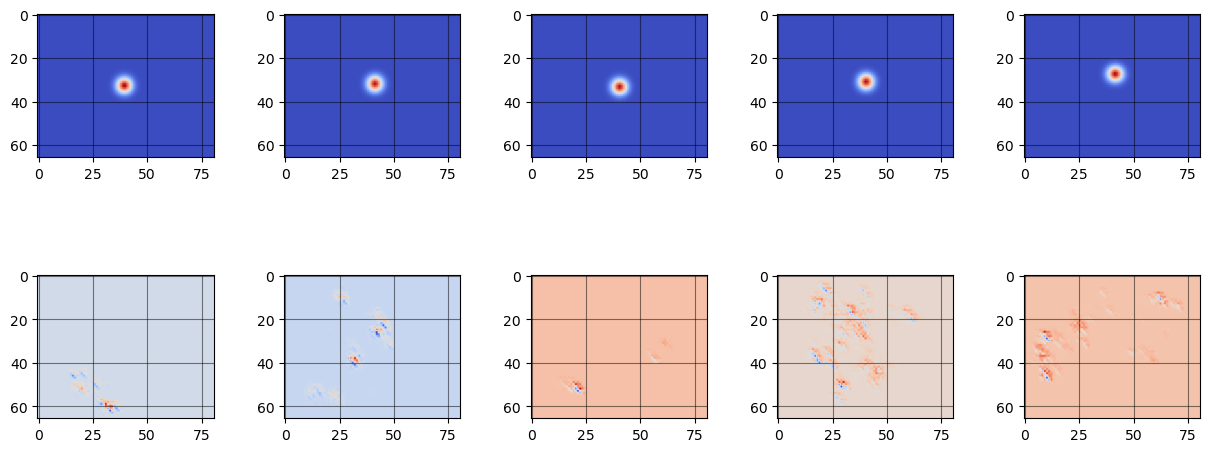

0.00063674117
sigma = 1.82008
67
	0.00061
	0.00062
	0.00062
	0.00061
	0.00066
	0.00065
	0.00062
	0.00062
	0.00068
	0.00065


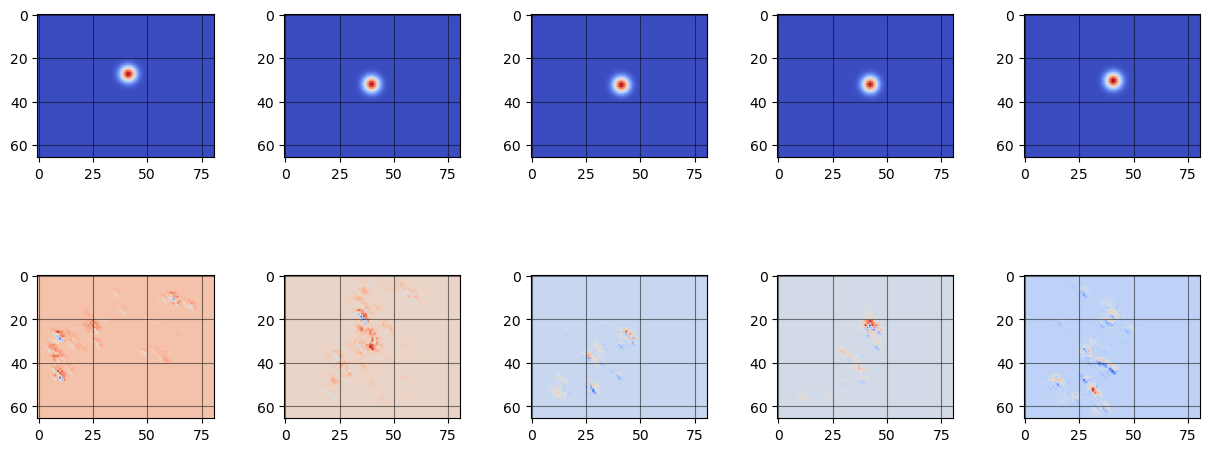

0.0006349841
sigma = 1.81756
68
	0.00063
	0.00064
	0.00058
	0.00070
	0.00064
	0.00065
	0.00064
	0.00065
	0.00062
	0.00058


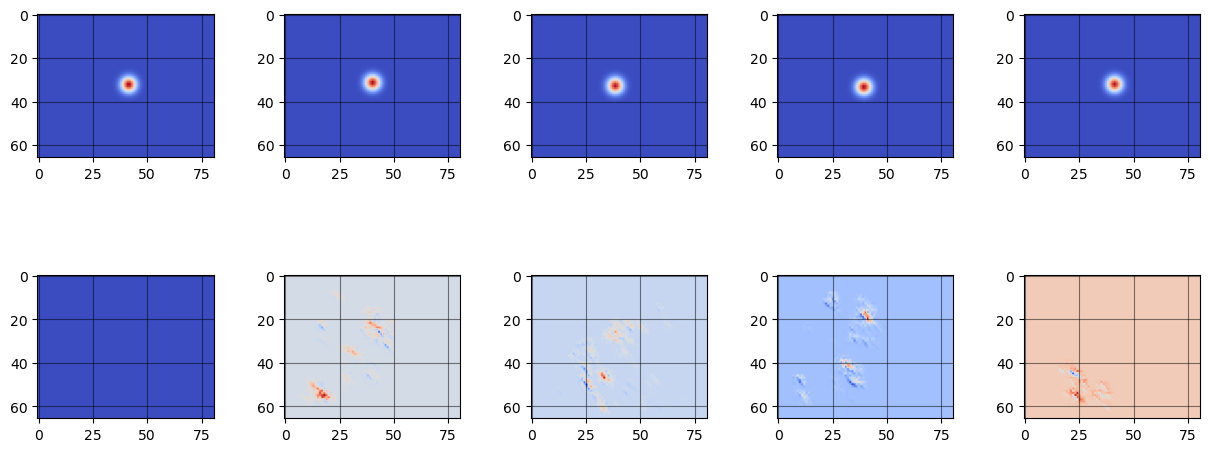

0.00063303387
sigma = 1.81504
69
	0.00064
	0.00062
	0.00069
	0.00069
	0.00057
	0.00059
	0.00062
	0.00064
	0.00063
	0.00063


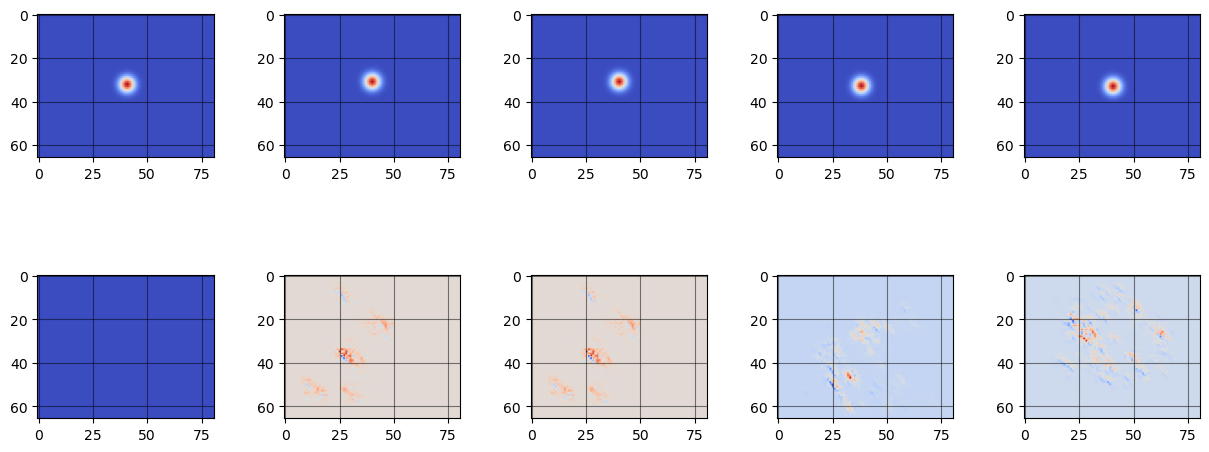

0.0006311908
sigma = 1.81252
70
	0.00064
	0.00060
	0.00064
	0.00066
	0.00063
	0.00064
	0.00059
	0.00060
	0.00061
	0.00068


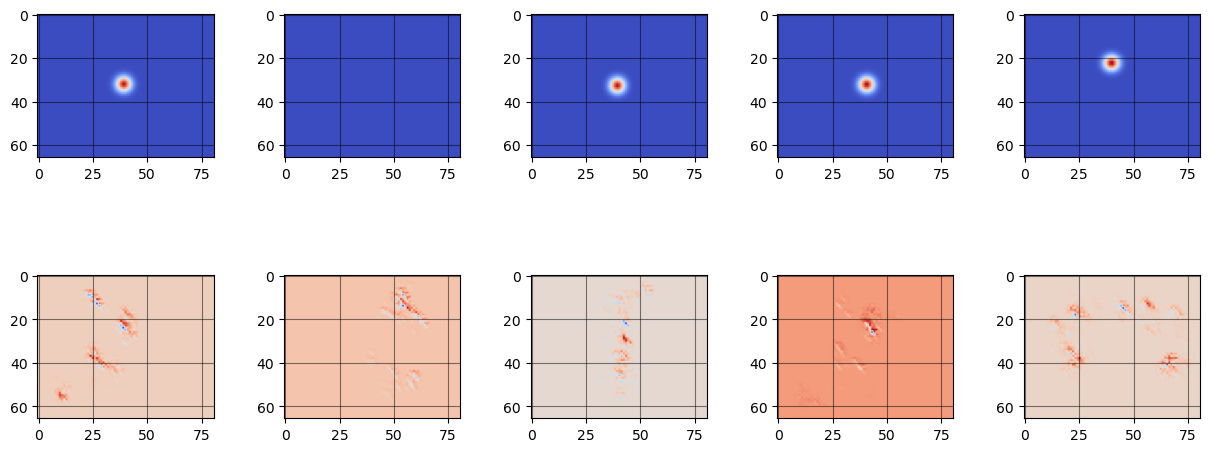

0.0006294587
sigma = 1.81001
71
	0.00058
	0.00062
	0.00064
	0.00072
	0.00059
	0.00058
	0.00060
	0.00063
	0.00065
	0.00067


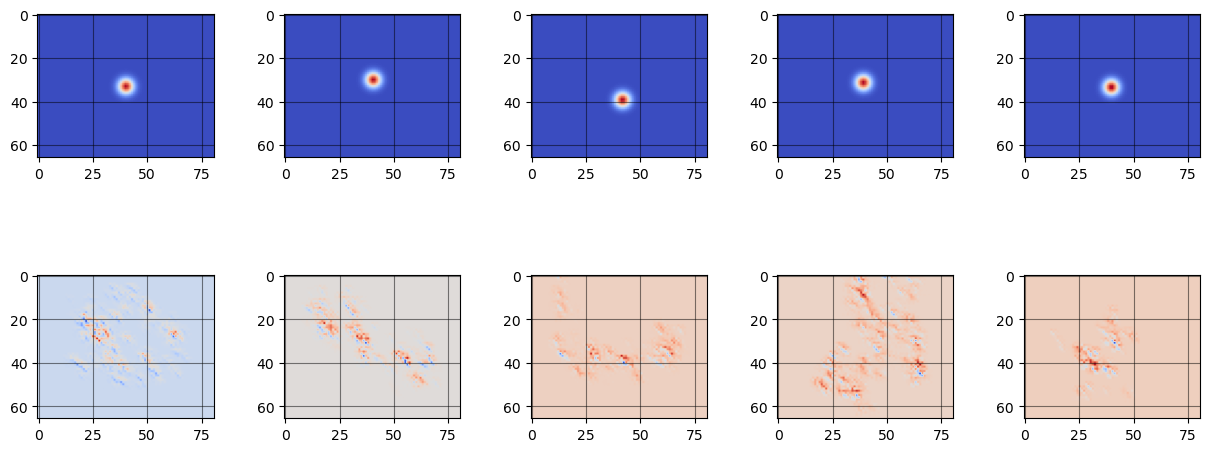

0.0006283128
sigma = 1.80751
72
	0.00064
	0.00062


KeyboardInterrupt: 

In [100]:
np.random.seed(123)
errors = []
losses = []

sigma_0 = sigma  = 2.
sigma_F = 1.0
epochs = 500

T      = 1 - np.exp( (1./epochs) * ( np.log(sigma_F) - np.log(sigma_0) )  )
for e in range(epochs):
    sigma =  (1 - T) * sigma
    print("sigma = %.5f" % sigma)
    print(e)
    batches_n  = 10
    
    indici     = np.random.choice(len(voxelizations),
                                  len(voxelizations),
                                  False)
    batches    = np.array_split( indici , batches_n)
    
    
    for batch in batches:
        vox,com = extract_batch(
            magic_shape,
            voxelizations,
            voxelization_specs,
            centers_of_mass,
            sigma = sigma,
            idx_list = batch
        )
            
        g      = batch_grad(    ktf,
                                btf,
                                vox,
                                com)
        lr  = 1e-1
        
        ktf = [ k - lr * gr for k,gr in zip(ktf, g[0])]
        btf = [ b - lr * gr for b,gr in zip(btf, g[1])]
        
        curr_loss = batch_loss( ktf,
                                btf,
                                vox,
                                com)
        
        errors.append(curr_loss)
        losses.append(np.mean(errors[-batches_n:]))
        print("\t%.5f" % curr_loss)
        
    #########################################################################################
    
    fetta = 15
    axs = plt.figure(figsize=(15,6)).subplots(2,5)
    plt.subplots_adjust(hspace = 0.3, wspace = 0.4) 

    
    samples = np.random.choice(len(voxelizations), size = 5)
    
    vox,com   = extract_batch(
            magic_shape,
            voxelizations,
            voxelization_specs,
            centers_of_mass,
            sigma = sigma,
            idx_list =  samples
        )
    
    for img,sample in enumerate(samples):
        axs[0,img].grid(visible=True, which='major', color='black', alpha = 0.5, linestyle='-')
        axs[1,img].grid(visible=True, which='major', color='black', alpha = 0.5, linestyle='-')


        axs[0,img].imshow( com[img][fetta,:,:] , cmap = 'coolwarm')
        
        axs[1,img].imshow( logistic_model(
                                  ktf, 
                                  btf,
                                  vox[img]
                                )[fetta,:,:] , alpha = 1.0, cmap = 'coolwarm' )
    
    plt.show()
    
    
    
    print(losses[-1])
    
    
plt.figure()
plt.plot(losses)

In [ ]:
axs = plt.figure(figsize=(15,6)).subplots(2,5)
plt.subplots_adjust(hspace = 0.3, wspace = 0.4) 

#np.random.seed(789)

for img in range(5):

    sample = np.random.choice(len(ligand_test))
    
    axs[0,img].set_title("correct %d" % sample)
    axs[0,img].grid(visible=True, which='major', color='black', alpha = 0.5, linestyle='-')
    
    axs[1,img].set_title("predicted %d" % sample)    
    axs[1,img].grid(visible=True, which='major', color='black', alpha = 0.5, linestyle='-')

    axs[0,img].imshow( anchorpts_vox_test[sample][fetta,:,:] , cmap = 'coolwarm')
    axs[1,img].imshow( logistic_model(
                              ktf, btf, wo, bo,
                              atomcoord_vox_test[sample],
                              ligand_test[sample], 
                              1.0)[fetta,:,:] , alpha = 1.0, cmap = 'coolwarm' )
    
    
plt.show()

## Save Big Model

In [30]:
import os

big_models_folders = "big_models"
N_models = len(next(os.walk(big_models_folders))[1])
new_folder_id = N_models


# creo la cartella
path_curr_model = big_models_folders + "/" + str(new_folder_id)
path_curr_model_ktf = "%s/ktf" % (path_curr_model)
path_curr_model_btf = "%s/btf" % (path_curr_model)
path_curr_model_wo  = "%s/wo"  % (path_curr_model)
path_curr_model_bo  = "%s/bo"  % (path_curr_model)

os.mkdir(path_curr_model)
os.mkdir(path_curr_model_ktf)
os.mkdir(path_curr_model_btf)
os.mkdir(path_curr_model_wo)
os.mkdir(path_curr_model_bo)


# Salvo i kernel
for i,k in enumerate(ktf):
    np.save(path_curr_model_ktf + ("/kernel_%d" % i) , np.array(k))

# Salvo i bias convolutivi
for i,b in enumerate(btf):
    np.save(path_curr_model_btf + ("/bias_%d" % i) , b)
    
# Salvo i weights dell'oracolo
for i,w in enumerate(wo):
    np.save(path_curr_model_wo + ("/weight_oracle_%d" % i) , w)

# Salvo i bias dell'oracolo
for i,b in enumerate(bo):
    np.save(path_curr_model_bo + ("/bias_oracle_%d" % i) , b)    


## salvo file con alcune informazioni
from datetime import datetime
 
# get current date and time
current_datetime = datetime.now().strftime("%Y-%m-%d %H-%M-%S")

# convert datetime obj to string
str_current_datetime = str(current_datetime)
# 
## create a file object along with extension
file_name = str_current_datetime+".log"
file = open(path_curr_model + "/" + file_name, 'w')
file.write(str_current_datetime + "\n")
file.write("TEST LOSS = %.10f\n" % batch_loss(  ktf, btf, wo, bo,
                                   extract_batch(magic_shape,atomcoord_vox_train,np.arange(len(ligand_test))),
                                   ligand_test,
                                   1.0,
                                   extract_batch(magic_shape,anchorpts_vox_train,np.arange(len(ligand_test)))))
file.close()


# salvo una copia dell autoencoder ligandi...

path_curr_model_encoder = "%s/ligand_encoder" % (path_curr_model)
path_curr_model_decoder = "%s/ligand_decoder" % (path_curr_model)

os.mkdir(path_curr_model_encoder)
os.mkdir(path_curr_model_decoder)

# Salvo l'encoder
for i,e in enumerate(params_E):
    np.save(path_curr_model_encoder + ("/encoder_param_%d" % i) , np.array(e))

# Salvo il decoder
for i,d in enumerate(params_D):
    np.save(path_curr_model_decoder + ("/decoder_param_%d" % i) , np.array(d))

# Test

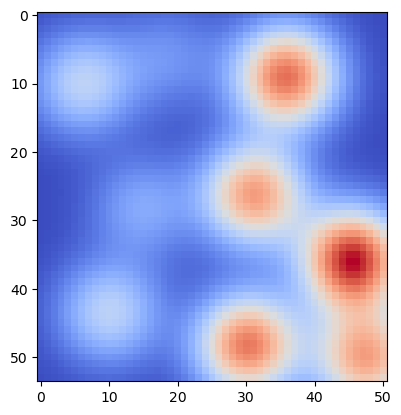

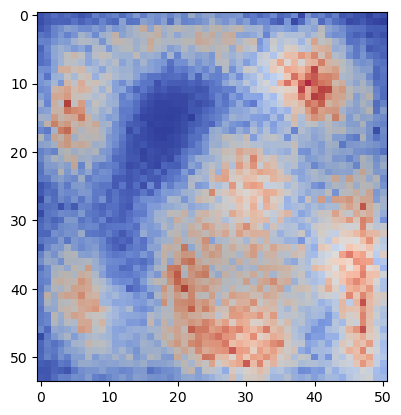

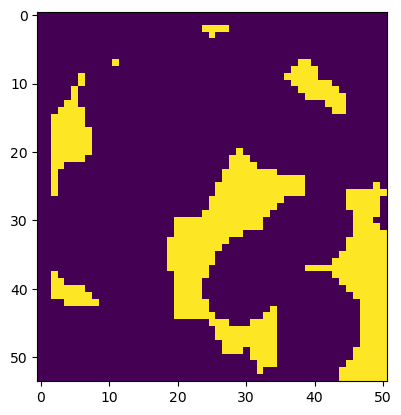

In [31]:
fetta = 20
sample = 1
plt.imshow( anchorpts_vox_test[sample][fetta,:,:] , cmap = 'coolwarm')
plt.figure()
plt.imshow( anchorpts_vox_test[sample][fetta,:,:] , cmap = 'gray')
plt.imshow(logistic_model(
                          ktf, btf, wo, bo,
                          atomcoord_vox_test[sample],
                          ligand_test[sample], 
                          1.0)[fetta,:,:] , alpha = 0.8, cmap = 'coolwarm' )
plt.figure()
plt.imshow( atomcoord_vox_test[sample][fetta,:,:])
plt.show()

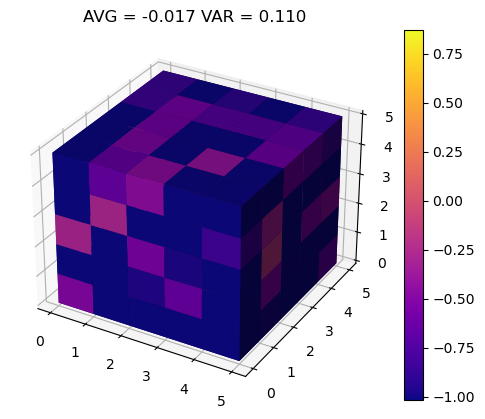

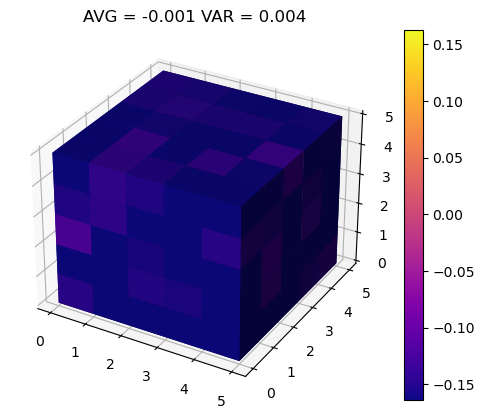

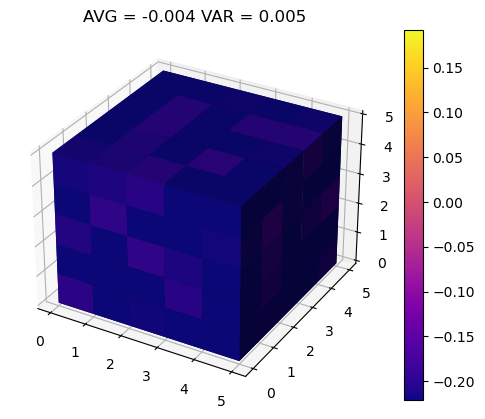

In [32]:
from matplotlib import colors,cm
for s in [10,20,30]:
    fig    = plt.figure()
    ax     = fig.add_subplot(projection = '3d')
    img    = chemical_contribution(wo,bo,ligand_train[s])
    ax.set_title("AVG = %.3f VAR = %.3f" % (img.mean(),img.var()))
    colori = plt.cm.plasma(img)
    v      = ax.voxels( img, facecolors = colori, alpha = 1. )

    norm = colors.Normalize(vmin=img.min(), vmax=img.max())
    m = cm.ScalarMappable(cmap=plt.cm.plasma, norm=norm)
    m.set_array([])
    plt.colorbar(m)
    plt.show()


In [82]:
sample = 17
V_A_hat = np.array  (
                    logistic_model
                                 (
                                      ktf, btf, wo, bo,
                                      atomcoord_vox_train[sample],
                                      ligand_train[sample], 
                                      1.0
                                 )
                    )
V_A     = np.array(anchorpts_vox_test[sample])
V_X     = np.array(atomcoord_vox_test[sample])

(array([44926., 29631., 19154., 17809., 18000., 16206., 16518., 17165.,
        15483.,   784.]),
 array([-0.03026948,  0.03291195,  0.09609338,  0.1592748 ,  0.22245623,
         0.28563765,  0.34881908,  0.4120005 ,  0.47518194,  0.5383634 ,
         0.6015448 ], dtype=float32),
 <BarContainer object of 10 artists>)

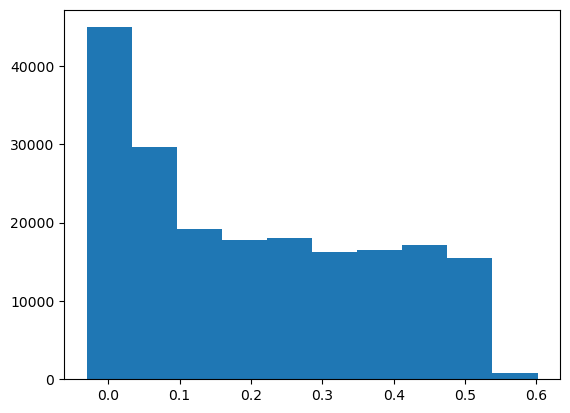

In [83]:
plt.hist( V_A_hat.flatten() )

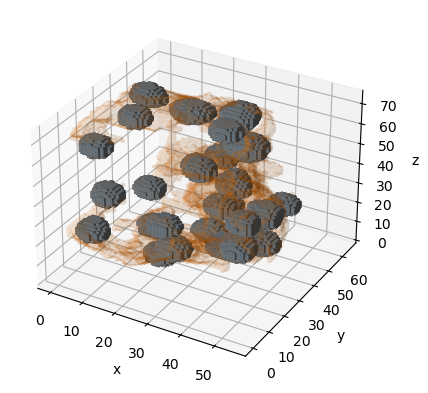

In [ ]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
def make_ax(grid=False):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.grid(grid)
    return ax

ax = make_ax(True)
ax.voxels(V_A > 0.7, edgecolors='gray', shade=True)
ax.voxels(V_X, edgecolors='gray', lw = 0., alpha = 0.1, shade=True)
plt.show()

ax = make_ax(True)
ax.voxels(V_A_hat > (0.8 * (V_A_hat.max() - V_A_hat.min()) + V_A_hat.min()), edgecolors='gray', shade=True)
ax.voxels(V_X, edgecolors='gray', lw = 0., alpha = 0.1, shade=True)
plt.show()

In [ ]:
V_A_hat.shape

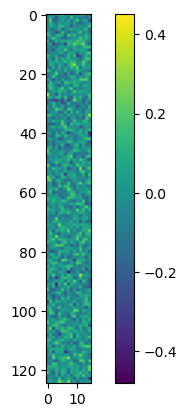

In [64]:
plt.imshow(W_6)
plt.colorbar()

In [127]:
b_f_4

DeviceArray(0.03047841, dtype=float32, weak_type=True)

$f({\bf x} + H_f^{-1} \nabla f({\bf x}) ) \approx f({\bf x}) + \nabla f({\bf x})^T H_f^{-1} \nabla f({\bf x})  + \nabla f({\bf x})^T H_f^{-1}  H_f({\bf x}) H_f^{-1} \nabla f({\bf x}) $

In [57]:
v = np.arange(5)**2
v[[0,2,3]]

array([0, 4, 9])